In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from env.area import Area

# Set seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)


def plot_histograms(projects, actions, area_pickle_file):
    contributors_per_project(projects)
    success_rate_over_time(projects)
    quality_metrics_over_time(projects)
    collab_metrics_over_time(projects)
    projects_per_contributor(projects)
    # prestige_per_project(projects)
    completion_per_project(projects)
    quality_per_project(projects)
    topic_area_per_project(projects, actions, area_pickle_file)

def societal_value_over_time(projects):
    # Convert to DataFrame
    df = pd.DataFrame(projects)

    # Sort by time
    df = df.sort_values("start_time")[df.start_time>100]

    # Compute cumulative sum and cumulative mean
    df["cumulative_societal_value"] = df["societal_value_score"].cumsum()
    df["cumulative_mean"] = df["cumulative_societal_value"] / (df.index + 1)

    # ==== Plot cumulative mean ====
    plt.figure(figsize=(8,6))
    plt.plot(df["start_time"], df["cumulative_mean"], linestyle="-", color="blue")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Mean Societal Value")
    plt.title("Cumulative Mean Societal Value Over Time")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def societal_value_per_archetype(agents, projects):
    # ==== Build agent → archetype map ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            idx = int(k.split('_')[1])   # extract numeric ID
            if v is not None:
                agent_archetype[idx] = v['archetype']
    # ==== Collect societal values per archetype ====
    records = []
    for p in projects:
        for contributor in p['contributors']:
            if contributor in agent_archetype:
                records.append({
                    'archetype': agent_archetype[contributor],
                    'societal_value': p['societal_value_score']
                })

    df = pd.DataFrame(records)
    # ==== Compute mean and error ====
    grouped = df.groupby("archetype")["societal_value"]
    means = grouped.mean()
    errors = grouped.std() / np.sqrt(grouped.count())  # Standard error of the mean
    # ==== Plot ====
    plt.figure(figsize=(8,6))
    means.plot(
        kind="bar",
        yerr=errors,
        capsize=5,
        color="skyblue",
        edgecolor="black"
    )
    plt.ylabel("Mean Societal Value (±SEM)")
    plt.title("Mean Societal Value per Archetype")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def reward_trajectories_over_time(reward_steps, agents):
    """
    Plots the accumulated reward trajectories of all agents over time,
    colored by archetype (one line per agent).
    reward_steps: list of dicts, each like {"agent_0": {"accumulated_rewards": ...}, ...}
    agents: list of agent dicts with archetypes (used to map IDs to archetypes)
    """
    # 1️⃣ Build agent → archetype mapping
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None:
                agent_archetype[k] = v["archetype"]

    # 2️⃣ Collect records per step
    records = []
    for step_idx, step in enumerate(reward_steps):
        for agent_id, data in step.items():
            if data is not None:
                data = data.get("observation", None)
                if "accumulated_rewards" in data:
                    archetype = agent_archetype.get(agent_id, None)
                    if archetype is not None:
                        records.append({
                            "step": step_idx,
                            "archetype": archetype,
                            "agent_id": agent_id,
                            "accumulated_rewards": data["accumulated_rewards"][0]
                        })

    df = pd.DataFrame(records)

    # 3️⃣ Plot all individual agent lines, colored by archetype
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df,
        x="step",
        y="accumulated_rewards",
        hue="archetype",
        units="agent_id",      # tells seaborn to plot one line per agent
        estimator=None,        # don’t average!
        alpha=0.15,            # transparency so lines overlap nicely
        lw=1
    )
    sns.lineplot(data=df, x="step", y="accumulated_rewards", hue="archetype", estimator="mean", lw=3)

    plt.title("Accumulated Rewards Over Time for All Agents")
    plt.xlabel("Time Step")
    plt.ylabel("Accumulated Reward")
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()    

def visualize_total_rewards_over_time(simulation_steps, agents):
    """
    Visualize the average accumulated rewards per archetype over time.

    Args:
        simulation_steps (list): A list of dicts, where each dict represents a simulation step
                                 and maps agent IDs (e.g., 'agent_0') to their state dicts,
                                 which include 'accumulated_rewards'.
        agents (list): A list of agent dicts (e.g. [{'agent_0': {...}}, {'agent_1': {...}}])
                       containing each agent's archetype.
    """

    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # ==== 1. Build agent → archetype mapping ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None and "archetype" in v:
                agent_archetype[k] = v["archetype"]
    # ==== 2. Collect records from all simulation steps ====
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent_id, data in step.items():
            if data is not None:
                data = data.get("observation", None)
                if "accumulated_rewards" in data:
                    archetype = agent_archetype.get(agent_id, None)
                    if archetype is not None:
                        records.append({
                            "step": step_idx,
                            "archetype": archetype,
                            "accumulated_rewards": data["accumulated_rewards"][0]
                        })
    df = pd.DataFrame(records)
    if df.empty:
        print("⚠️ No data available to plot (check input formats).")
        return

    # ==== 3. Compute mean reward per archetype per time step ====
    mean_rewards = (
        df.groupby(["step", "archetype"])["accumulated_rewards"]
        .mean()
        .reset_index()
        .sort_values("step")
    )

    # ==== 4. Plot ====
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=mean_rewards,
        x="step",
        y="accumulated_rewards",
        hue="archetype",
        linewidth=2.0
    )

    plt.title("Average Accumulated Rewards per Archetype Over Time")
    plt.xlabel("Simulation Step")
    plt.ylabel("Mean Accumulated Reward")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_cumulative_citations_over_time(projects, agents):
    """
    Visualize the mean number of cumulative citations per archetype over time.

    Each project contributes its citation count to *all* its contributors'
    archetypes (not just the dominant one).

    Args:
        projects (list): List of project dicts with keys:
                         - 'start_time': float or int
                         - 'citations': list of cited project IDs
                         - 'contributors': list of agent indices
        agents (list): List of agent dicts, e.g. [{'agent_0': {...}}, {'agent_1': {...}}]
                       Each agent dict must include an 'archetype' key.
    """

    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # ==== 1. Build agent → archetype mapping ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None and "archetype" in v:
                agent_id = int(k.split("_")[1])
                agent_archetype[agent_id] = v["archetype"]

    # ==== 2. Collect project citation data for all contributors ====
    records = []
    for p in projects:
        citation_count = len(p.get("citations", []))
        for contributor in p.get("contributors", []):
            archetype = agent_archetype.get(contributor)
            if archetype:
                records.append({
                    "start_time": p["start_time"],
                    "archetype": archetype,
                    "citations": citation_count
                })

    df = pd.DataFrame(records)
    if df.empty:
        print("⚠️ No valid project or agent data to plot.")
        return

    # ==== 3. Sort and compute cumulative stats ====
    df = df.sort_values("start_time")

    cumulative_records = []
    for archetype, group in df.groupby("archetype"):
        group = group.sort_values("start_time")
        # cumulative sum of citations
        group["cumulative_citations"] = group["citations"].cumsum()
        # mean cumulative value (averaged across projects up to that point)
        group["mean_cumulative_citations"] = group["cumulative_citations"].expanding().mean()
        cumulative_records.append(group)

    cumulative_df = pd.concat(cumulative_records)

    # ==== 4. Plot ====
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=cumulative_df,
        x="start_time",
        y="mean_cumulative_citations",
        hue="archetype",
        linewidth=2.0
    )
    plt.ylim(bottom=1)
    plt.yscale("log")  # <-- add this line
    plt.title("Mean Cumulative Citations per Archetype Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Mean Cumulative Citations (log scale)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def contributors_per_project(projects):
    num_contributors = [len(p["contributors"]) for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(num_contributors, bins=range(1, max(num_contributors) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Contributors")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Contributors per Project")
    plt.tight_layout()
    plt.show()


def projects_per_contributor(projects):
    all_contributors = []
    for p in projects:
        all_contributors.extend(p["contributors"])

    author_counts = Counter(all_contributors)
    papers_per_author = list(author_counts.values())

    plt.figure(figsize=(8, 5))
    sns.histplot(papers_per_author, bins=range(1, max(papers_per_author) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Papers per Author")
    plt.ylabel("Number of Authors")
    plt.title("Authors by Number of Papers")
    plt.tight_layout()
    plt.show()


def prestige_per_project(projects):
    prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

    plt.figure(figsize=(6, 4))
    sns.histplot(prestige_categories, bins=range(1, max(prestige_categories)), kde=False, discrete=True)
    plt.xlabel("Prestige Category (mod 3)")
    plt.ylabel("Number of Projects")
    plt.title("Projects per Prestige Category")
    plt.tight_layout()
    plt.show()


def completion_per_project(projects):
    completion = [max(0, p["current_effort"] / p["required_effort"]) * 100 for p in projects]
    plt.figure(figsize=(8, 5))
    sns.histplot(completion, bins=range(0, 110, 10), kde=False, discrete=True)
    plt.xlabel("Completion (%)")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Completion")
    plt.tight_layout()
    plt.show()


def quality_per_project(projects):
    quality_scores = [p["quality_score"] for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(quality_scores, bins=[i/10 for i in range(0, 11)], kde=False)
    plt.xlabel("Quality Score")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Quality Scores")
    plt.tight_layout()
    plt.show()

def success_rate_over_time(projects):
    """
    Plots the cumulative success rate of projects (finished / started)
    over time, using 'start_time' and 'finished' from the projects list.
    """
    # Extract (start_time, finished) for each project
    events = [(p["start_time"], p["finished"], p["final_reward"]) for p in projects]

    # Sort by start time
    events.sort(key=lambda x: x[0])

    time_steps = []
    success_rates = []

    finished = 0
    successful = 0

    for t, is_finished, score in events:
        if is_finished:
            finished += 1
            if score > 0:
                successful += 1
        success_rate = successful/ finished if finished > 0 else 0
        time_steps.append(t)
        success_rates.append(success_rate)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=time_steps, y=success_rates)
    plt.xlabel("Time Step")
    plt.ylabel("Success Rate")
    plt.title("Project Success Rate Over Time")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

def quality_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in one line plot.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]:[] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, p in projects_sorted]
    quality = [np.mean([p["quality_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    novelty = [np.mean([p["novelty_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    value = [np.mean([p["societal_value_score"] for p in pjs]) for _, pjs in projects_sorted]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=times, y=quality, label="Quality Score")
    sns.lineplot(x=times, y=novelty, label="Novelty")
    sns.lineplot(x=times, y=value, label="Societal Value")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Project Metrics Over Time")
    plt.legend()
    # plt.tight_layout()
    plt.show()

def collab_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in three side-by-side plots.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]: [] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, _ in projects_sorted]
    effort = [np.mean([p["current_effort"] for p in pjs]) for _, pjs in projects_sorted]
    n_contributors = [np.mean([len(p["contributors"]) for p in pjs]) for _, pjs in projects_sorted]
    citations = [np.sum([len(p["citations"]) for p in pjs]) for _, pjs in projects_sorted]

    # Create 1 row, 3 column subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot effort
    sns.lineplot(x=times, y=effort, ax=axes[0])
    axes[0].set_title("Current Effort")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Effort")

    # Plot contributors
    sns.lineplot(x=times, y=n_contributors, ax=axes[1])
    axes[1].set_title("# Contributors per Paper")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("# Contributors")

    # Plot citations
    sns.lineplot(x=times, y=citations, ax=axes[2])
    axes[2].set_title("Citations")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Citations")

    plt.tight_layout()
    plt.show()



def topic_area_per_project(projects, actions, area_pickle_file):
    area = Area.load(area_pickle_file)
    papers = []
    agent_to_archetype = {}
    for step in actions:
        for agent, action in step.items():  # assume step is a list of agent dicts
            if action is not None and not agent in agent_to_archetype:
                agent_to_archetype[agent] = action["archetype"]
    for p in projects:
        main_archetype = Counter([agent_to_archetype[f"agent_{c}"] for c in p["contributors"]]).most_common(1)[0][0]
        papers.append((*p["kene"],main_archetype))
    area.visualize(sampled_points=papers)

def visualize_policy_population_proportion(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their proportions over time as a stacked area chart.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a list of agent dicts
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Normalize to proportions
    proportions = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked area chart
    plt.figure()
    proportions.plot.area(colormap="tab20", alpha=0.85, figsize=(12, 8))

    plt.title("Archetype Proportions Over Simulation Steps")
    plt.xlabel("Step")
    plt.ylabel("Proportion")
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_policy_population(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their absolute counts over time as a line plot.
    Also shows the total number of agents per step in a smaller panel underneath.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a dict of agents
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Compute total per step
    total_counts = pivot.sum(axis=1)

    # Two subplots: main plot + smaller panel underneath
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Top: archetype counts
    pivot.plot.line(ax=axes[0])
    axes[0].set_title("Archetype Counts Over Simulation Steps")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Bottom: total counts
    total_counts.plot(ax=axes[1], color="black")
    axes[1].set_title("Total Agents")
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Total Count")

    plt.tight_layout()
    plt.show()

In [2]:
# Load projects list from JSON file
with open("../log/balanced_evenly_projects.json", "r") as f:
    balanced_evenly_projects = json.load(f)
with open("../log/balanced_evenly_actions.jsonl", "r") as f:
    balanced_evenly_actions = []
    for line in f.readlines():
        balanced_evenly_actions.append(json.loads(line))
with open("../log/balanced_evenly_observations.jsonl", "r") as f:
    balanced_evenly_observations = []
    for line in f.readlines():
        balanced_evenly_observations.append(json.loads(line))
with open("../log/balanced_multiply_projects.json", "r") as f:
    balanced_multiply_projects = json.load(f)
with open("../log/balanced_multiply_actions.jsonl", "r") as f:
    balanced_multiply_actions = []
    for line in f.readlines():
        balanced_multiply_actions.append(json.loads(line))
with open("../log/balanced_multiply_observations.jsonl", "r") as f:
    balanced_multiply_observations = []
    for line in f.readlines():
        balanced_multiply_observations.append(json.loads(line))
with open("../log/balanced_by_effort_projects.json", "r") as f:
    balanced_by_effort_projects = json.load(f)
with open("../log/balanced_by_effort_actions.jsonl", "r") as f:
    balanced_by_effort_actions = []
    for line in f.readlines():
        balanced_by_effort_actions.append(json.loads(line))
with open("../log/balanced_by_effort_observations.jsonl", "r") as f:
    balanced_by_effort_observations = []
    for line in f.readlines():
        balanced_by_effort_observations.append(json.loads(line))

MULTIPLY


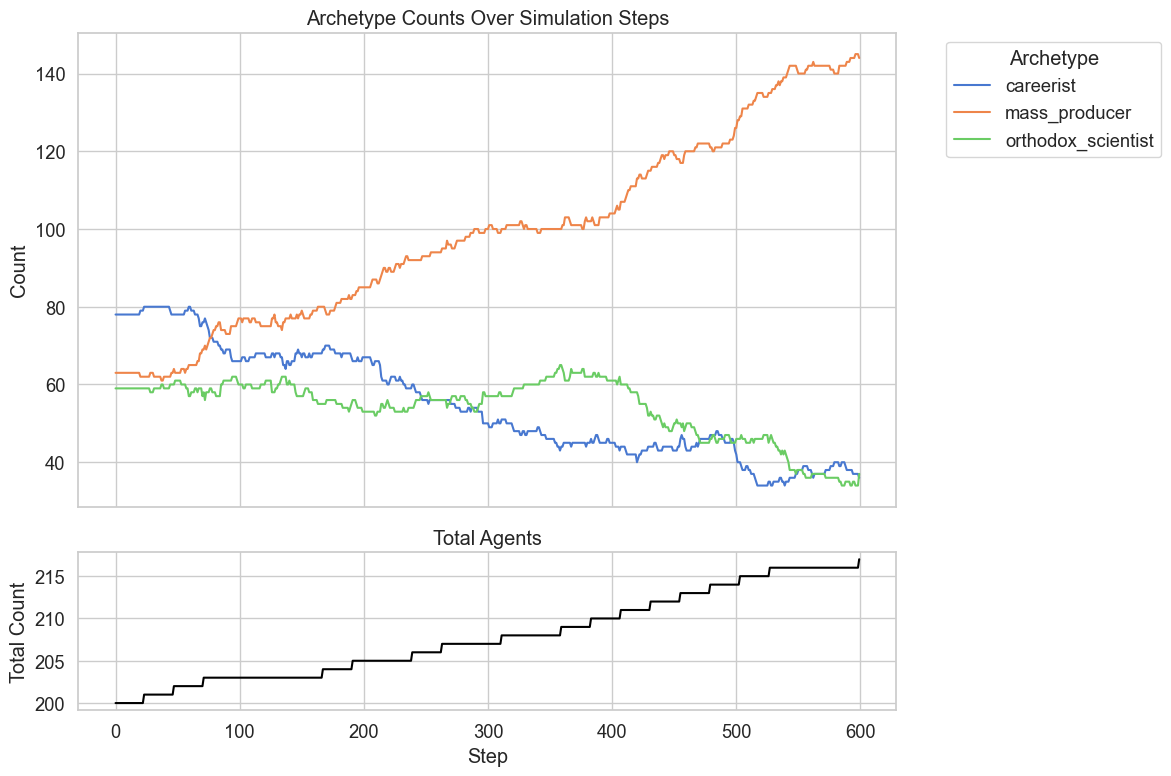

MULTIPLY


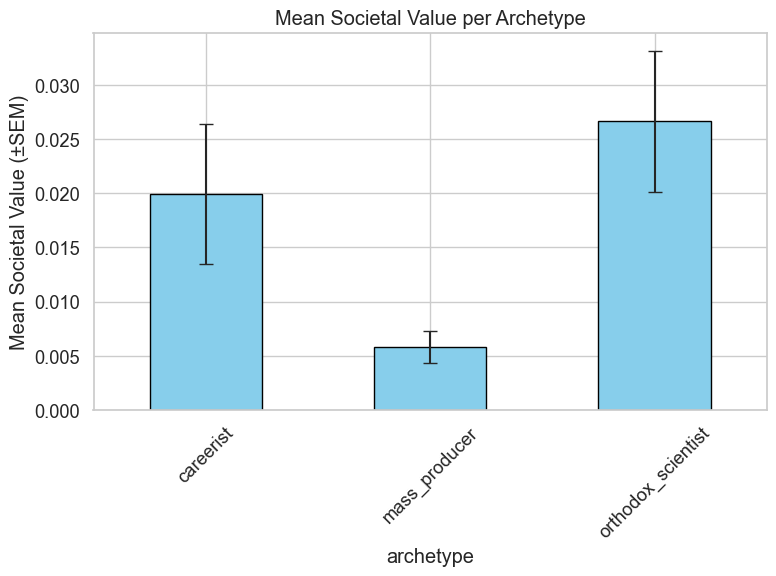

MULTIPLY


/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5919/441076337.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


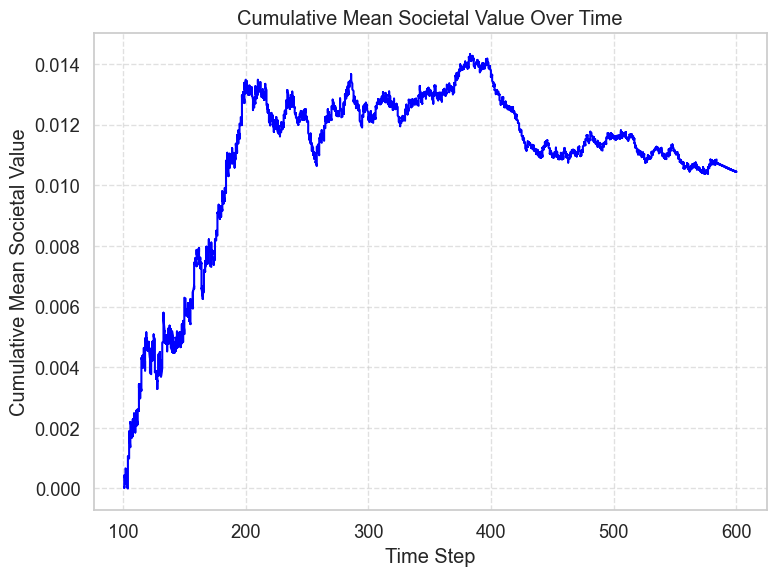

MULTIPLY


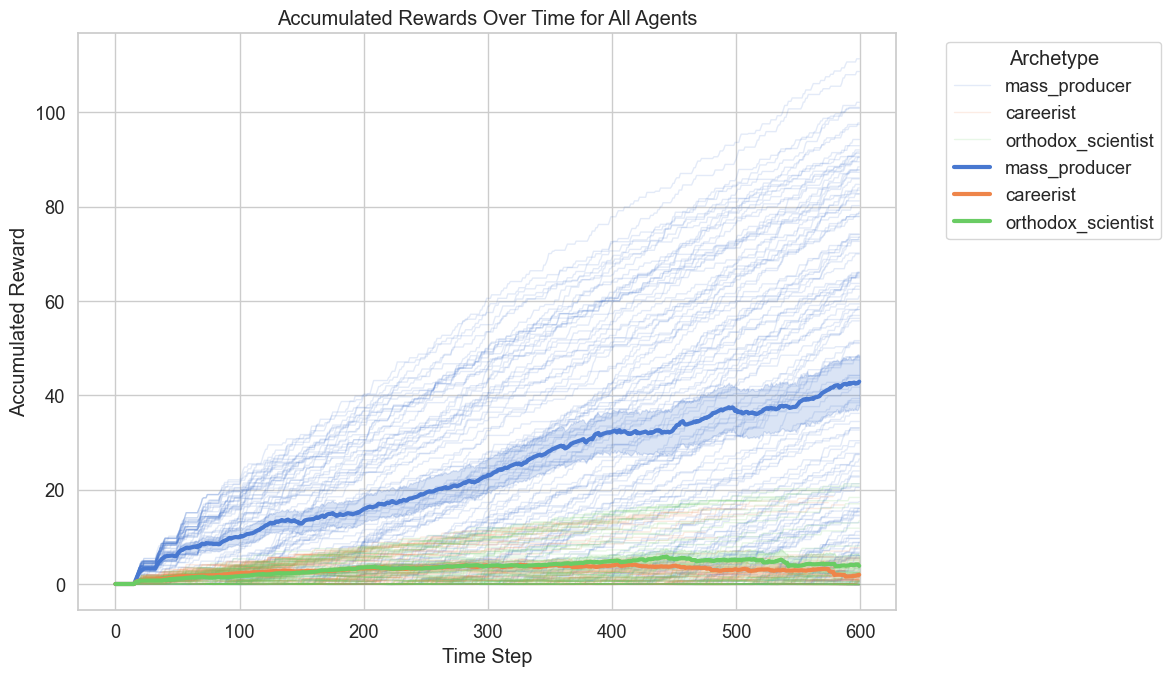

MULTIPLY


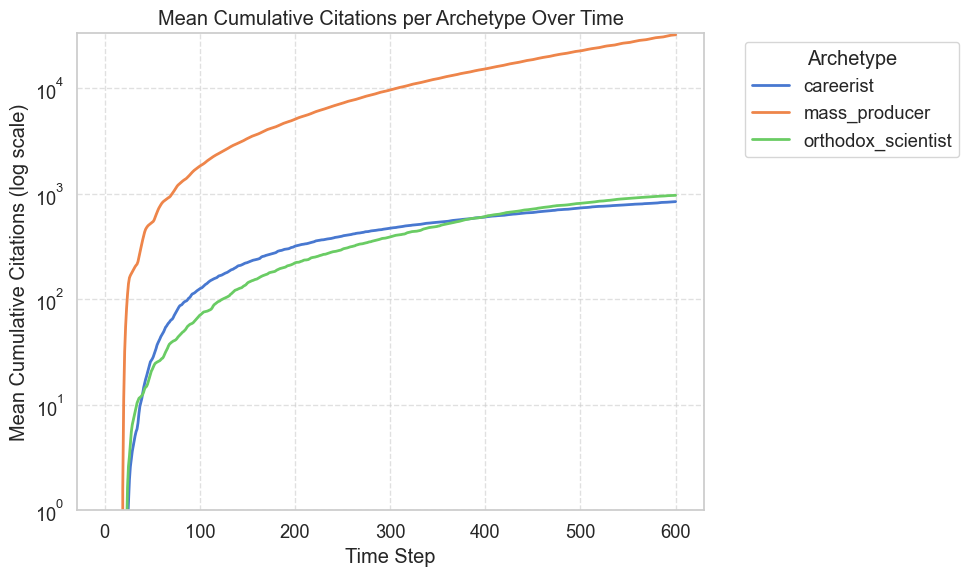

EVENLY


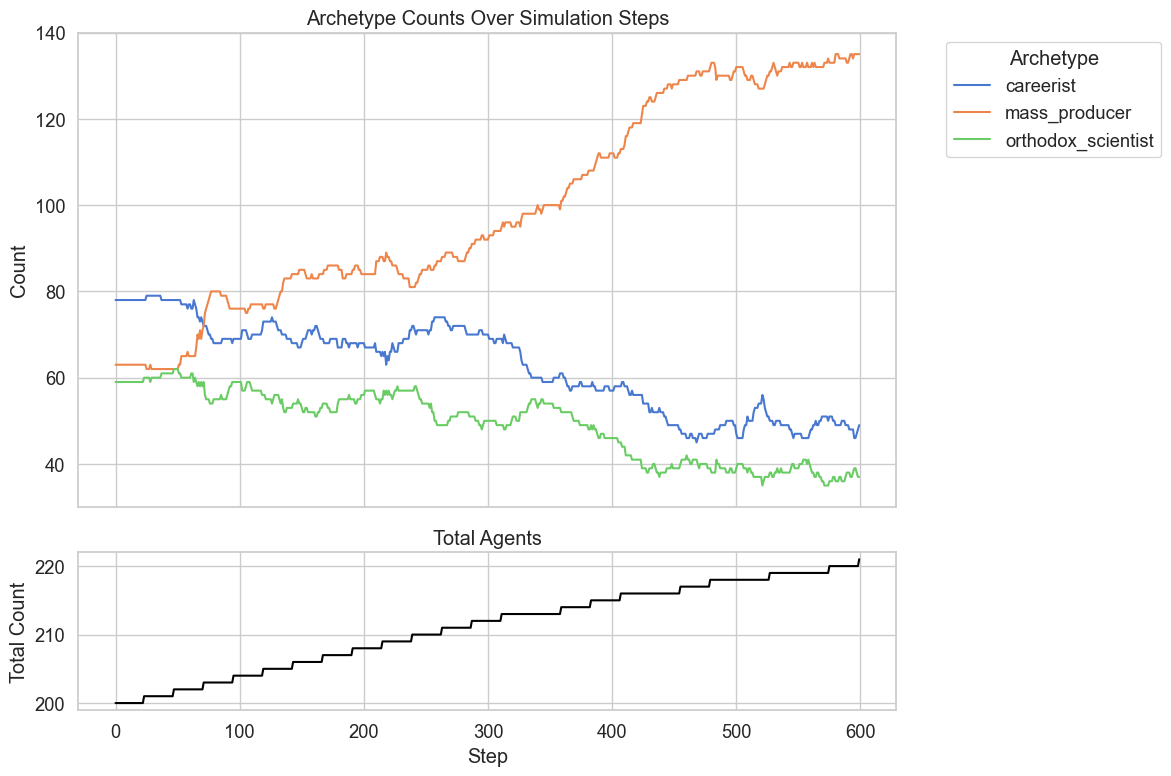

EVENLY


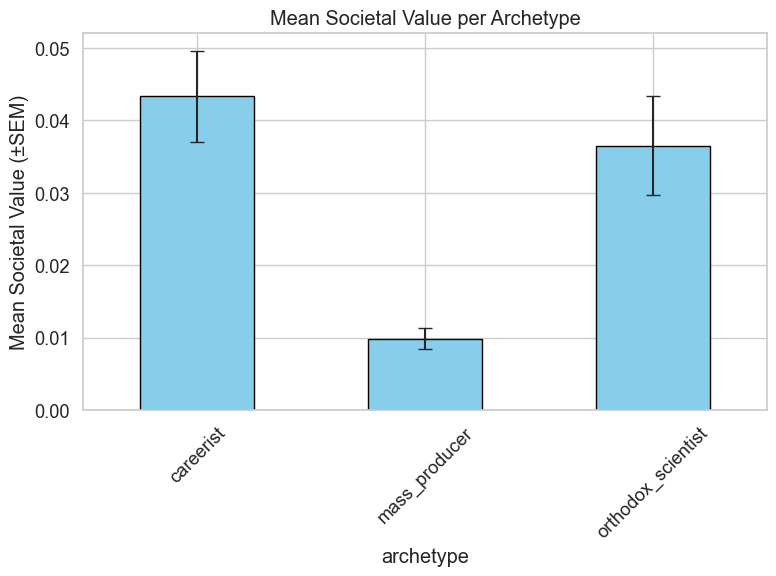

EVENLY


/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5919/441076337.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


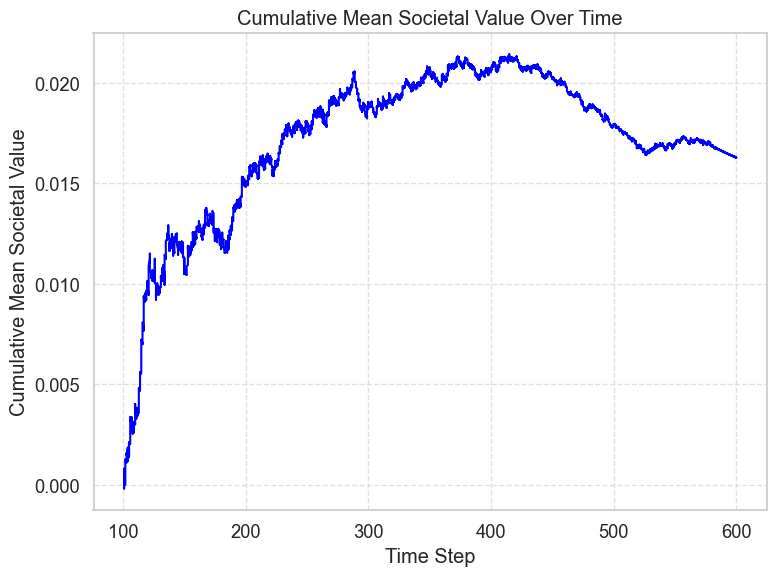

EVENLY


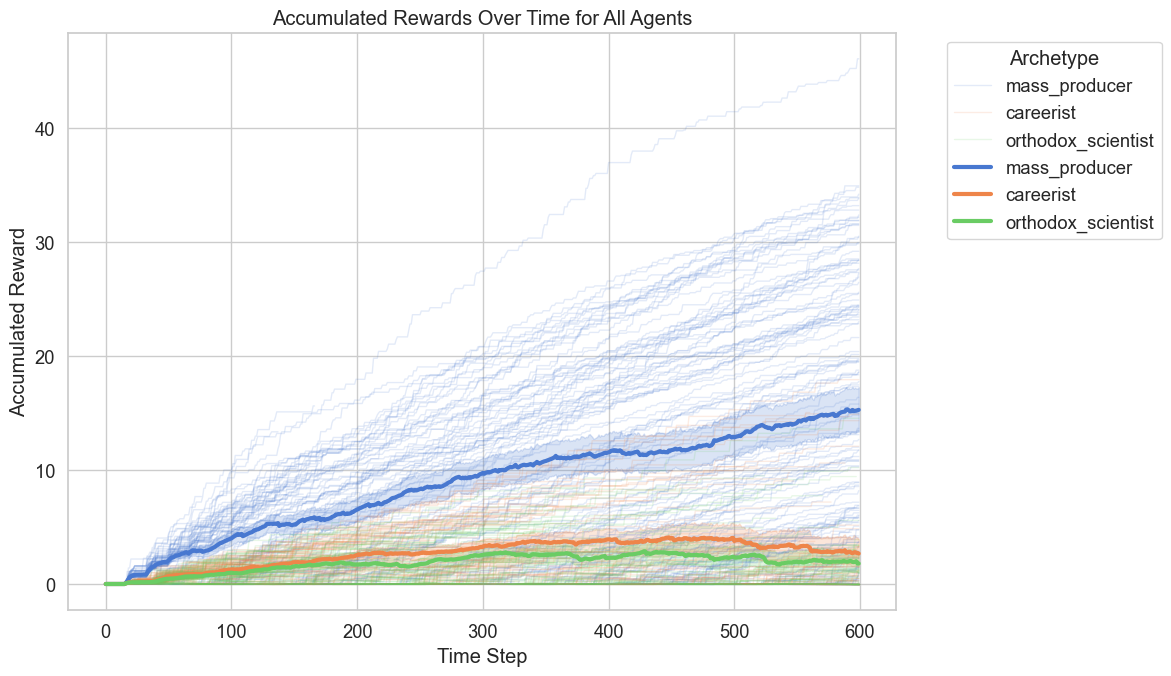

EVENLY


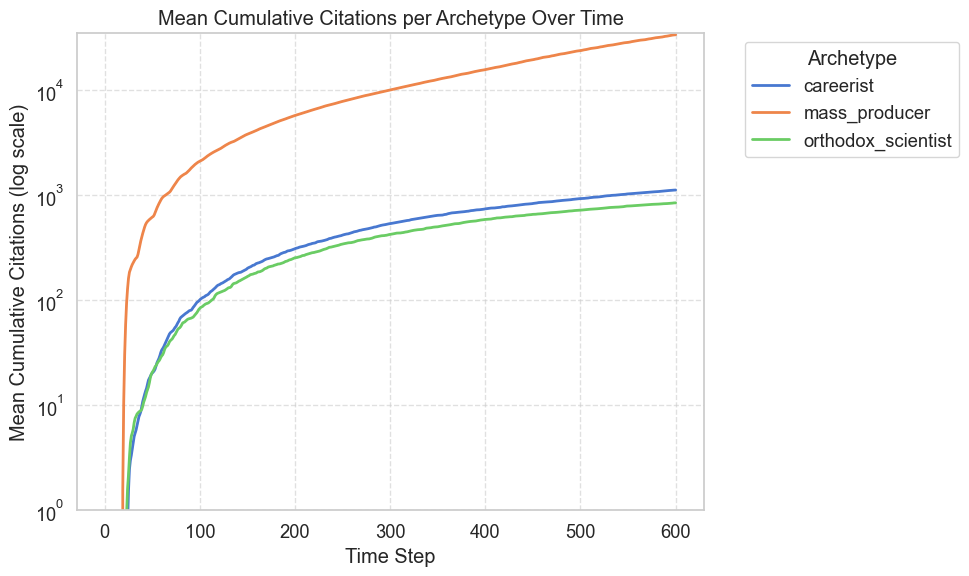

BY EFFORT


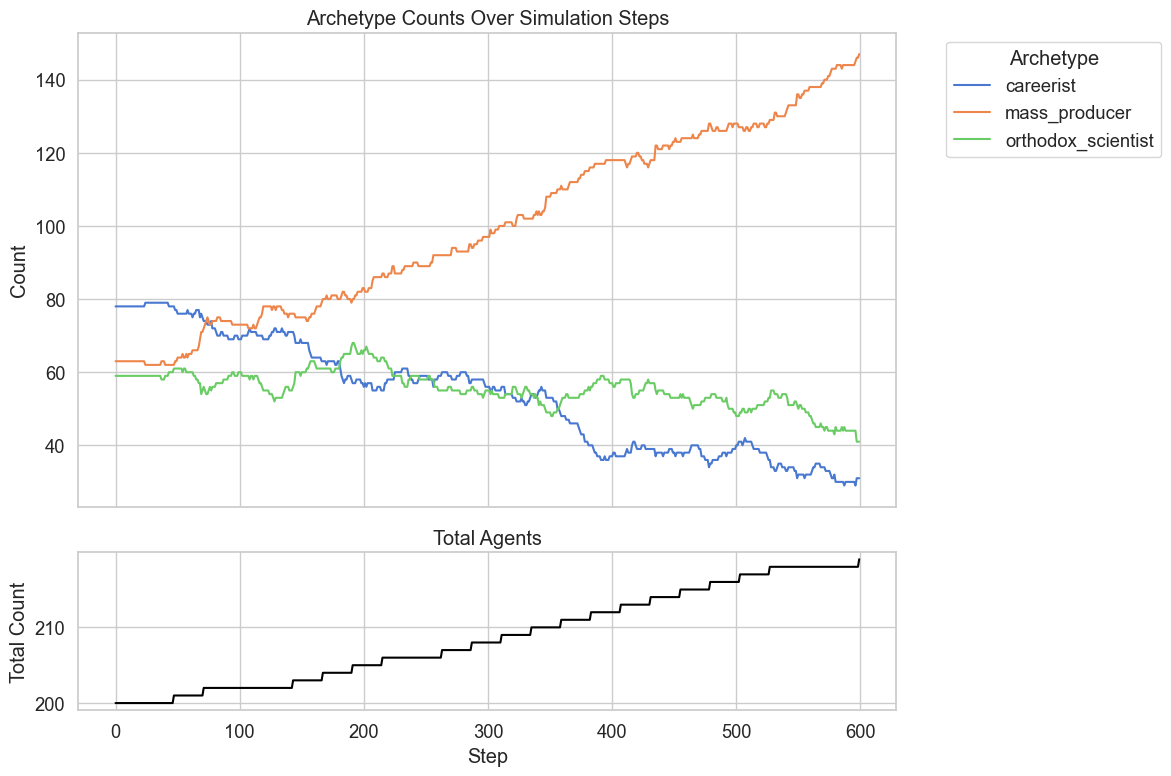

BY EFFORT


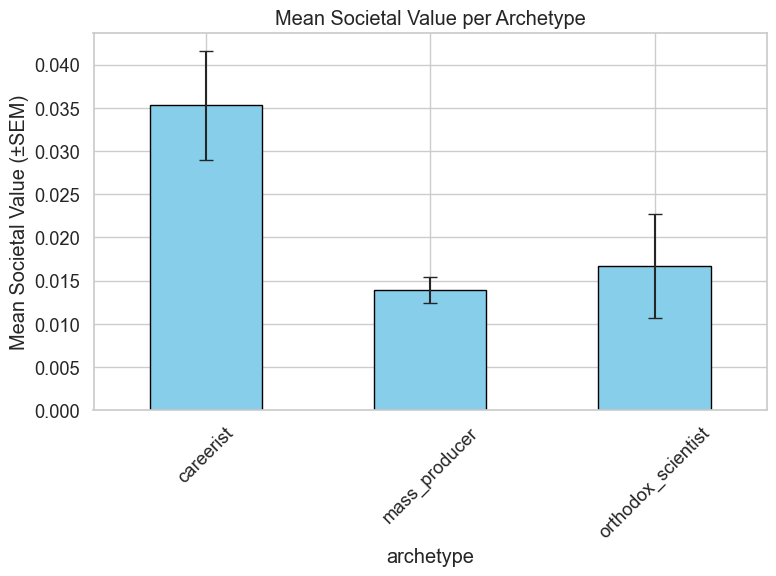

BY EFFORT


/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5919/441076337.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


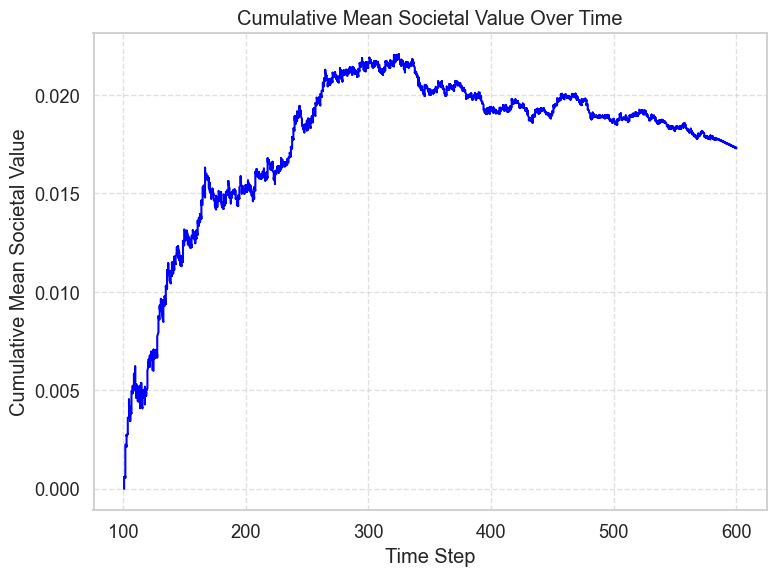

BY EFFORT


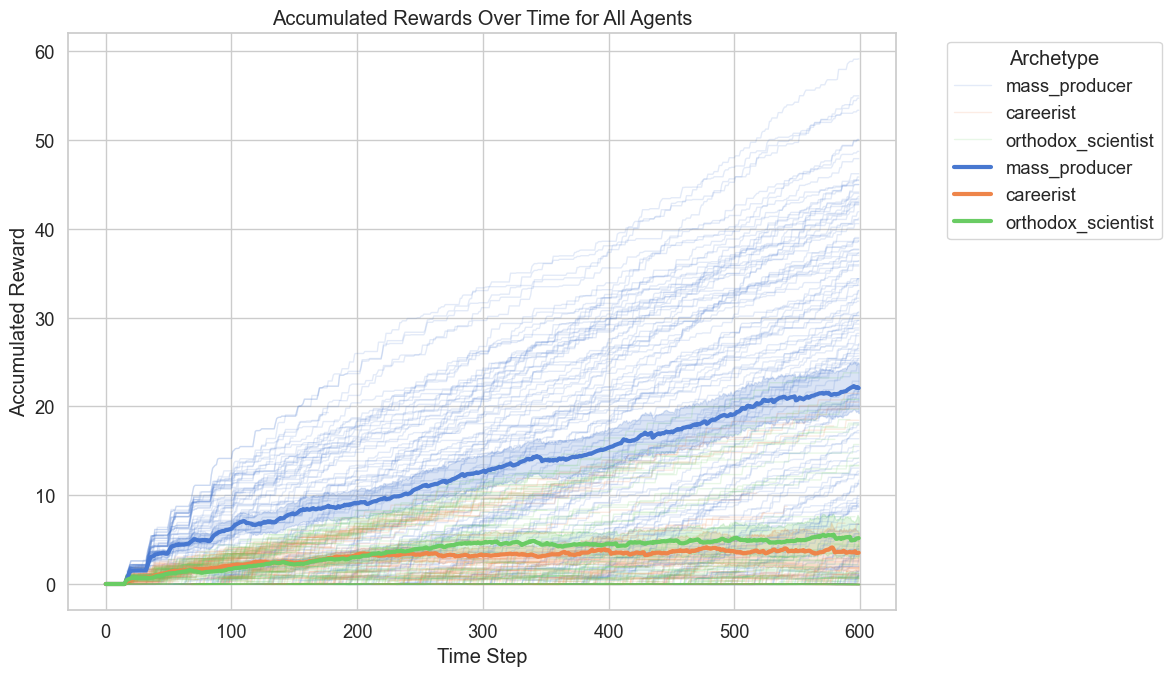

BY EFFORT


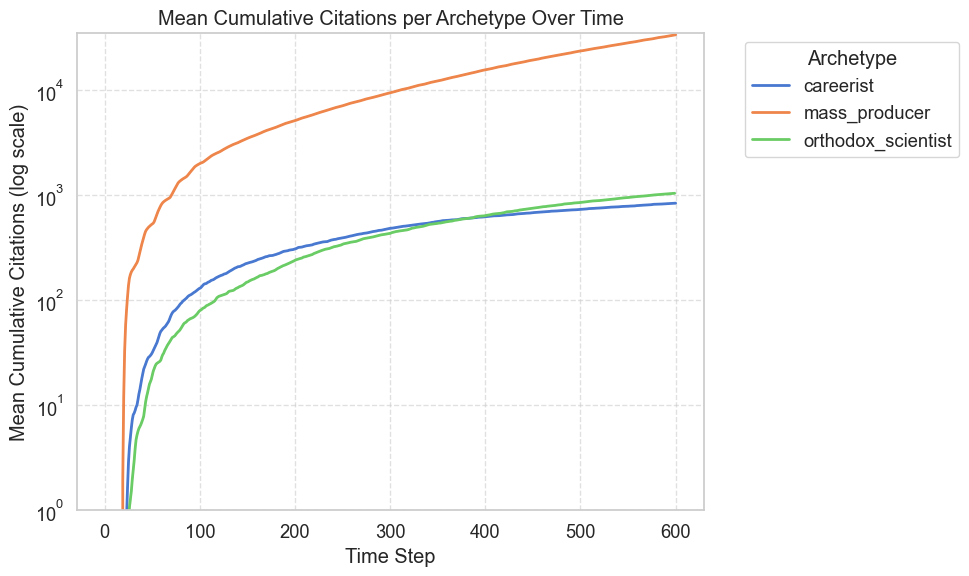

In [3]:

print("MULTIPLY")
visualize_policy_population(balanced_multiply_actions)
print("MULTIPLY")
societal_value_per_archetype(balanced_multiply_actions, balanced_multiply_projects)
print("MULTIPLY")
societal_value_over_time(balanced_multiply_projects)
print("MULTIPLY")
reward_trajectories_over_time(balanced_multiply_observations, balanced_multiply_actions)
# visualize_total_rewards_over_time(balanced_multiply_observations, balanced_multiply_actions)
print("MULTIPLY")
visualize_cumulative_citations_over_time(balanced_multiply_projects, balanced_multiply_actions)
print("EVENLY")
visualize_policy_population(balanced_evenly_actions)
print("EVENLY")
societal_value_per_archetype(balanced_evenly_actions, balanced_evenly_projects)
print("EVENLY")
societal_value_over_time(balanced_evenly_projects)
print("EVENLY")
reward_trajectories_over_time(balanced_evenly_observations, balanced_evenly_actions)
# visualize_total_rewards_over_time(balanced_evenly_observations, balanced_evenly_actions)
print("EVENLY")
visualize_cumulative_citations_over_time(balanced_evenly_projects, balanced_evenly_actions)
print("BY EFFORT")
visualize_policy_population(balanced_by_effort_actions)
print("BY EFFORT")
societal_value_per_archetype(balanced_by_effort_actions, balanced_by_effort_projects)
print("BY EFFORT")
societal_value_over_time(balanced_by_effort_projects)
print("BY EFFORT")
reward_trajectories_over_time(balanced_by_effort_observations, balanced_by_effort_actions)
# visualize_total_rewards_over_time(balanced_by_effort_observations, balanced_by_effort_actions)
print("BY EFFORT")
visualize_cumulative_citations_over_time(balanced_by_effort_projects, balanced_by_effort_actions)

<Figure size 640x480 with 0 Axes>

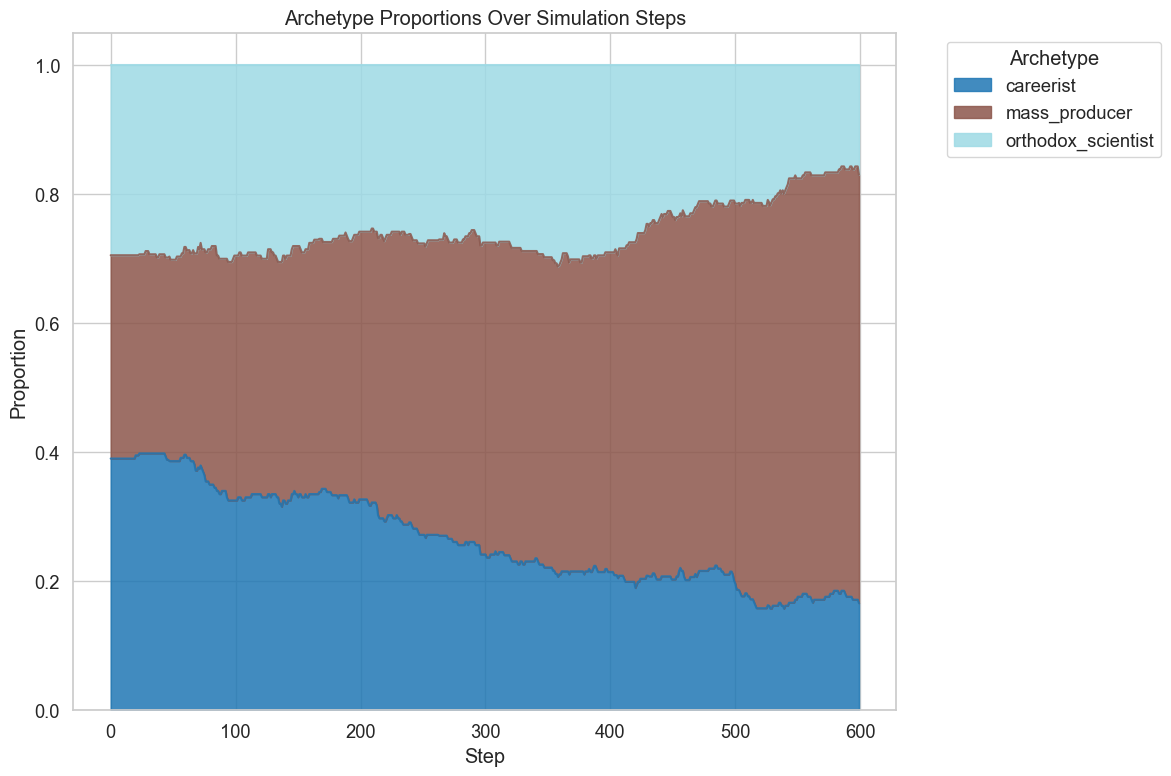

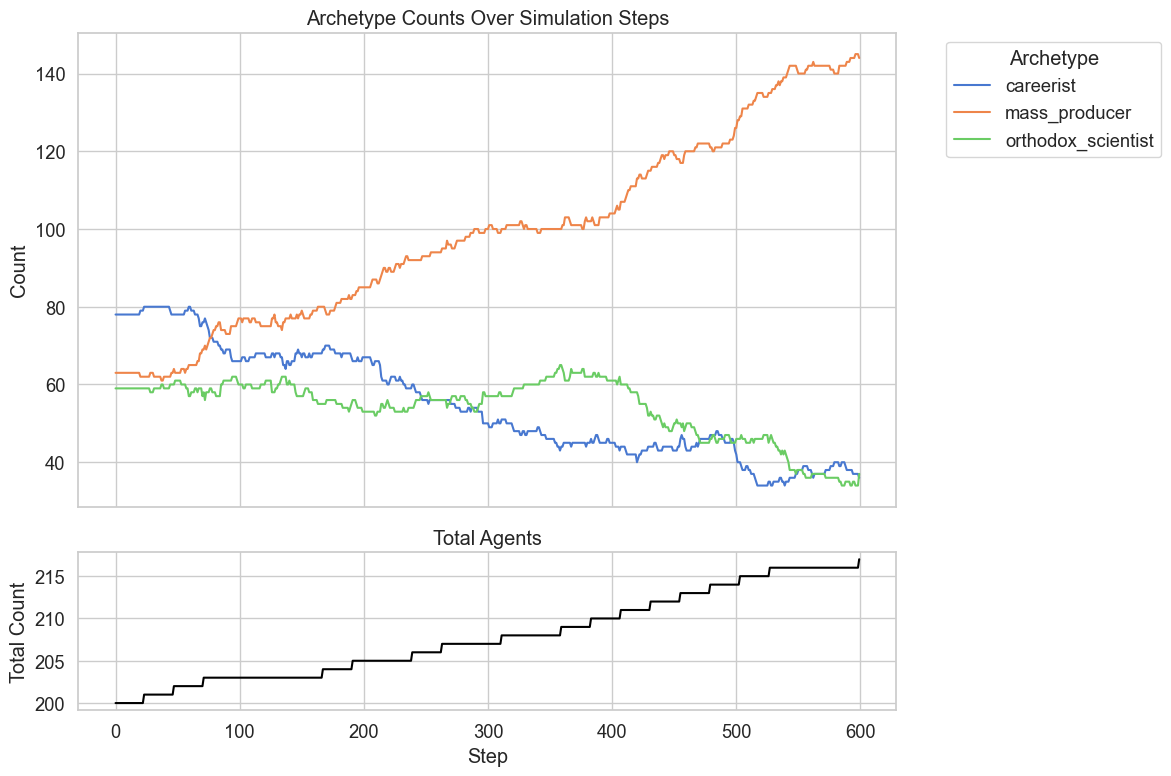

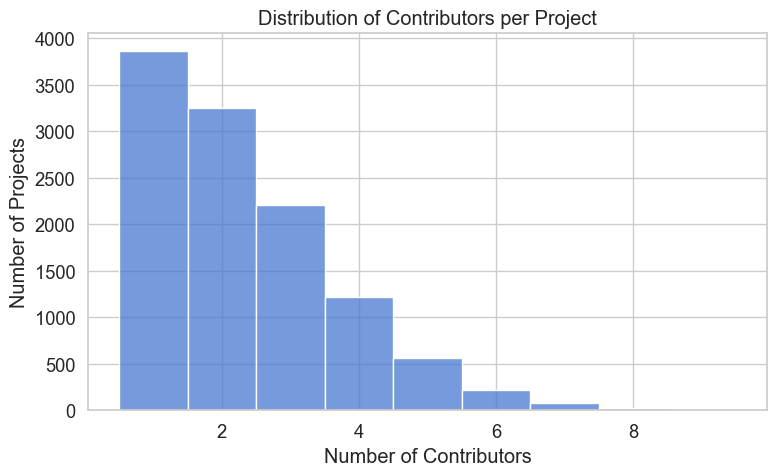

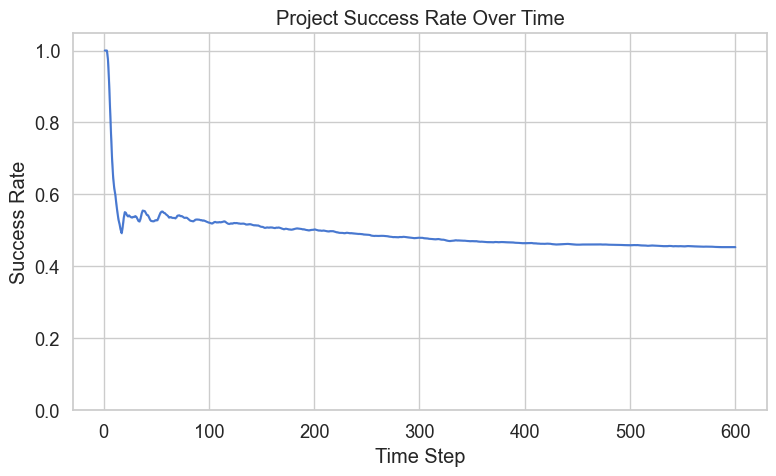

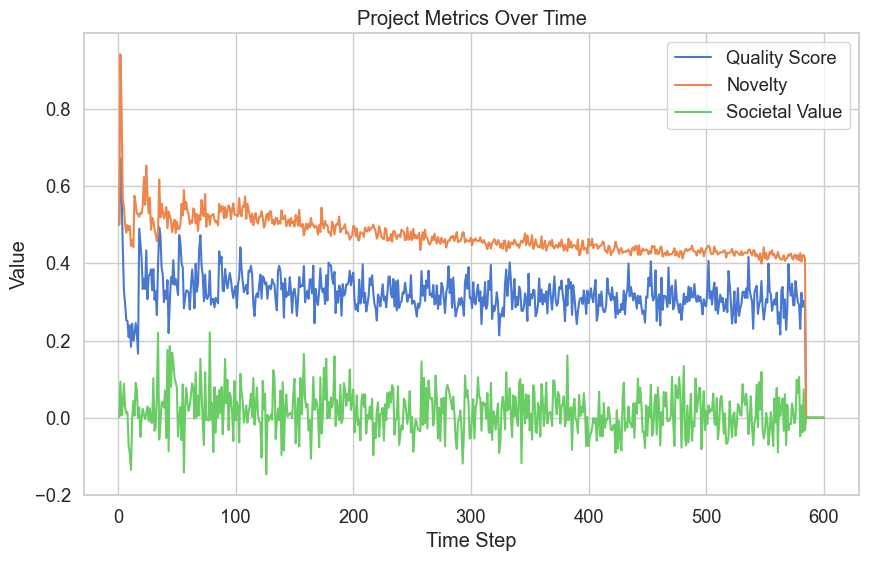

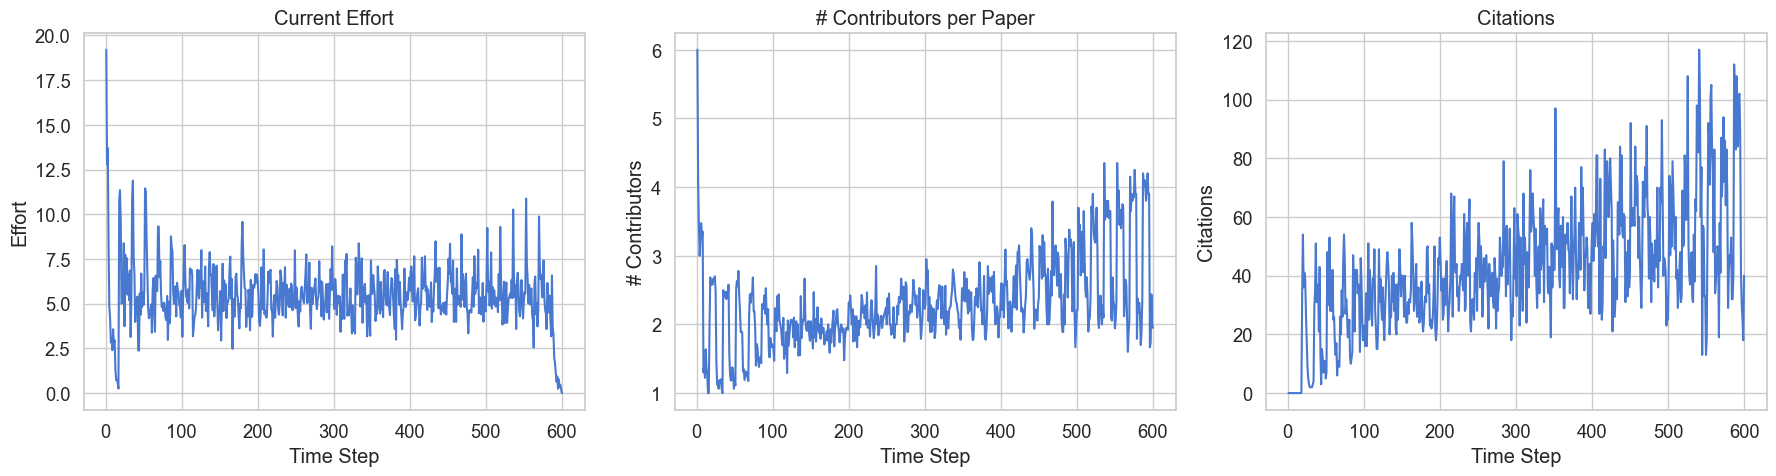

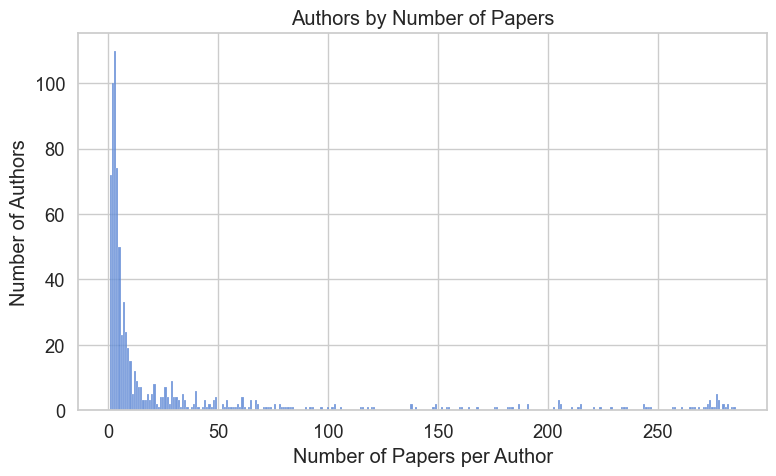

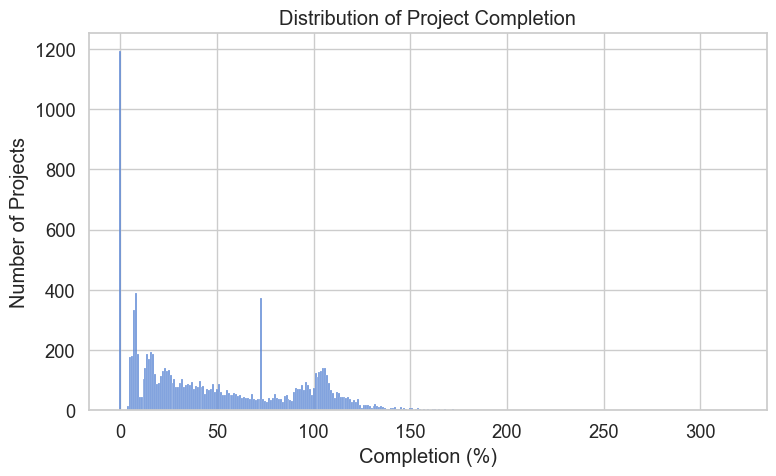

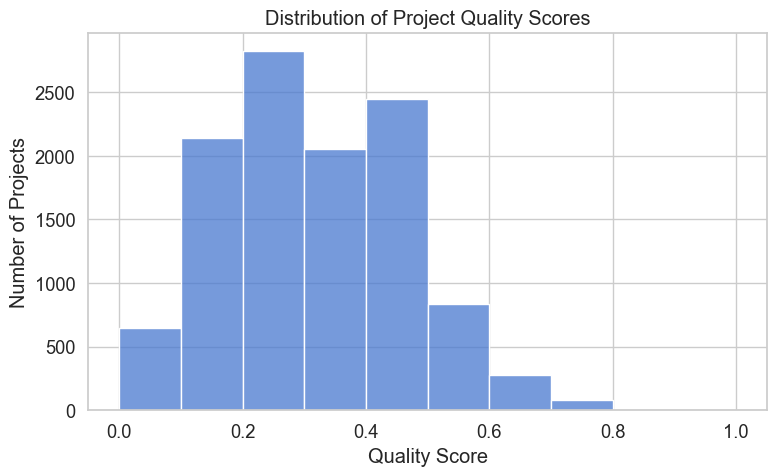

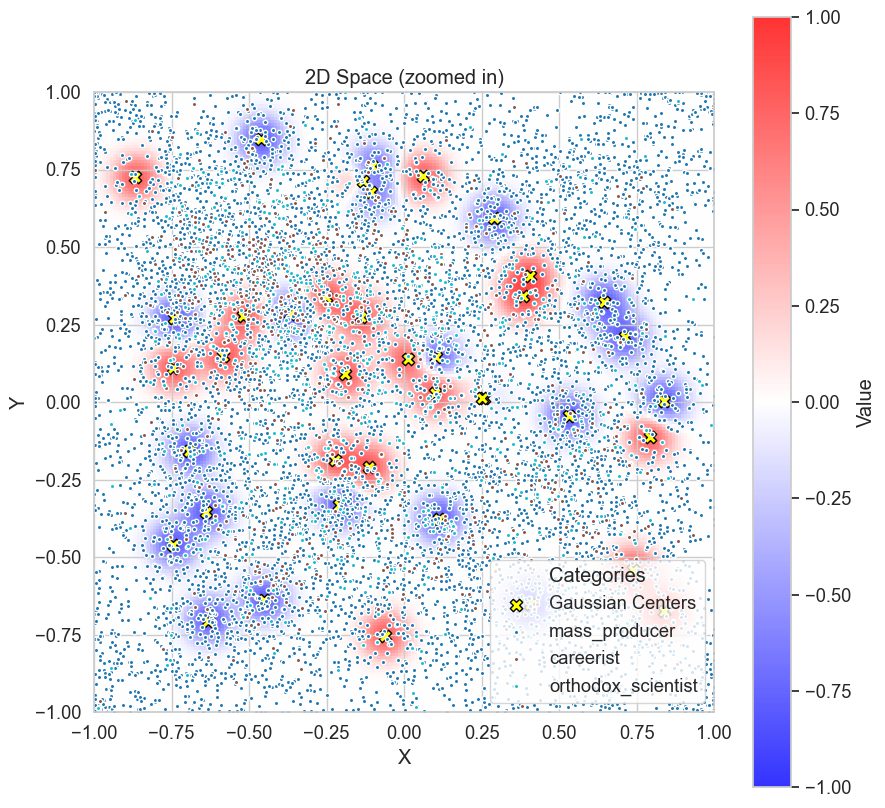

In [4]:

visualize_policy_population_proportion(balanced_multiply_actions)
visualize_policy_population(balanced_multiply_actions)
plot_histograms(balanced_multiply_projects, balanced_multiply_actions, "../log/balanced_multiply_area.pickle")


<Figure size 640x480 with 0 Axes>

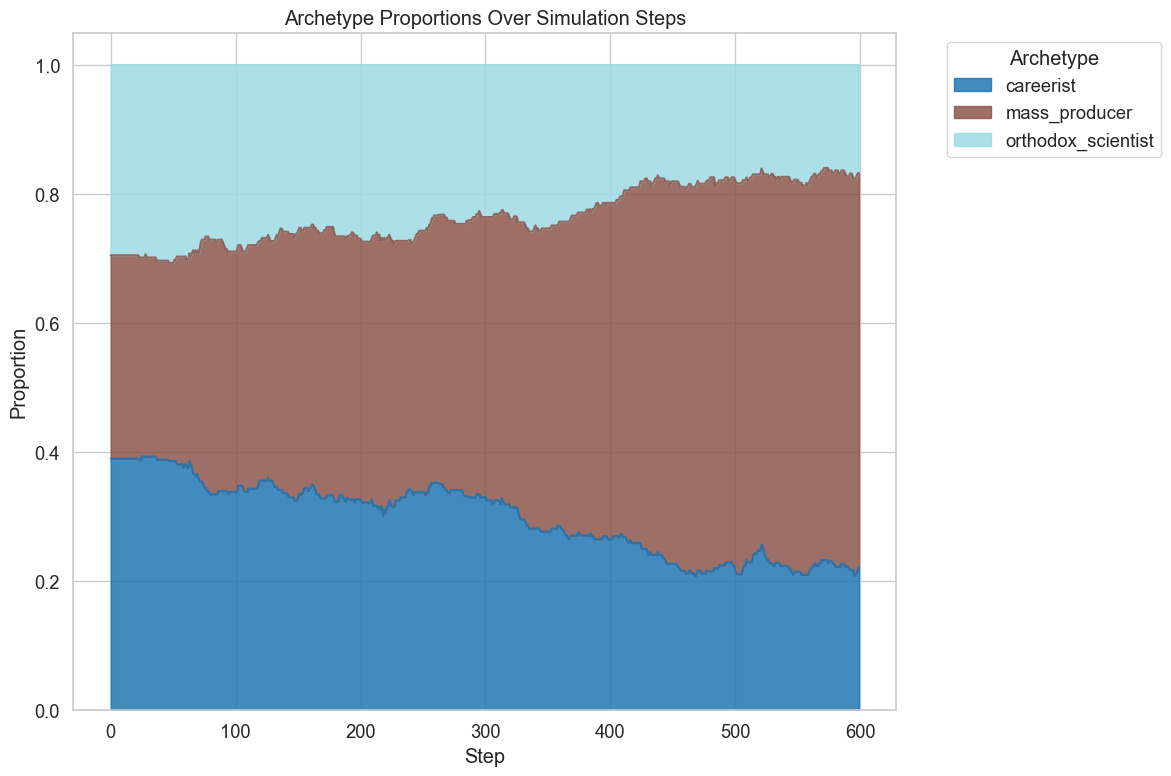

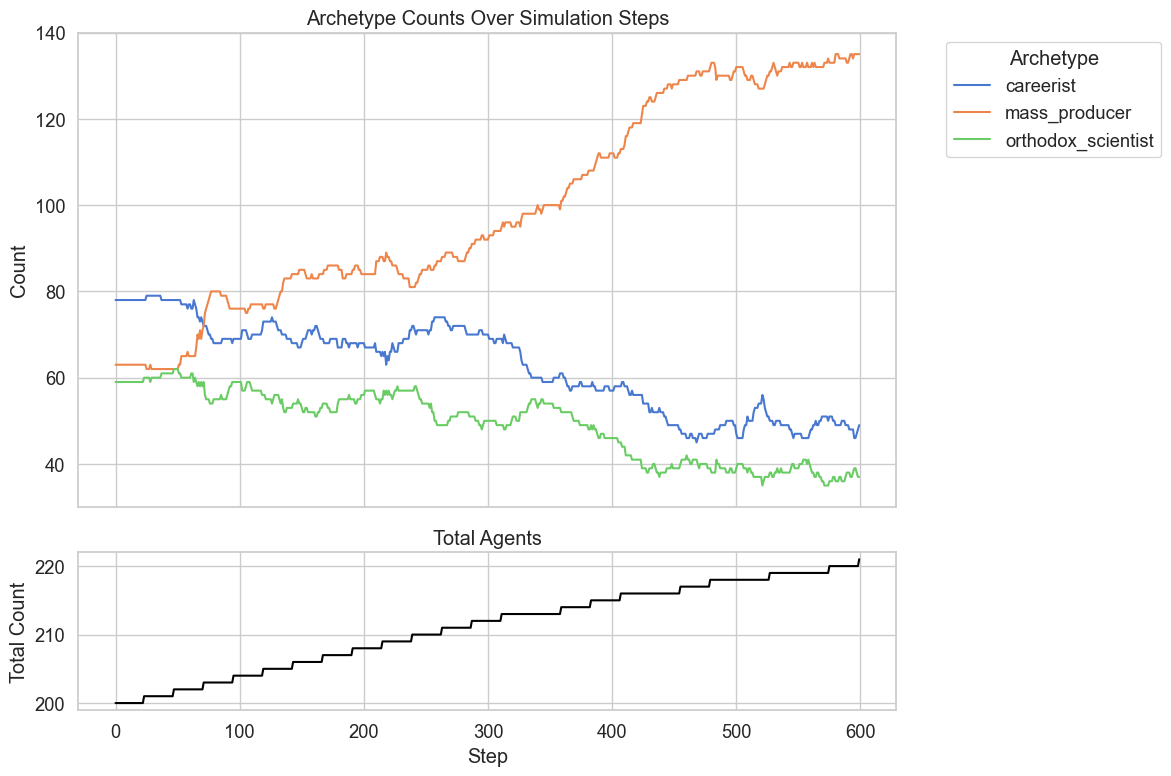

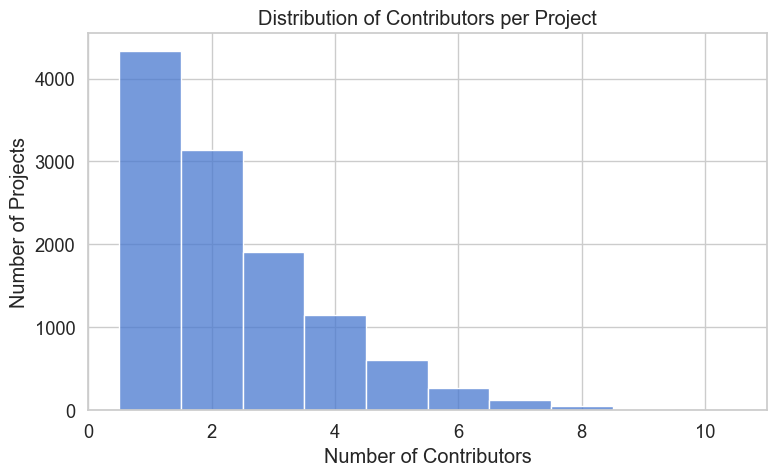

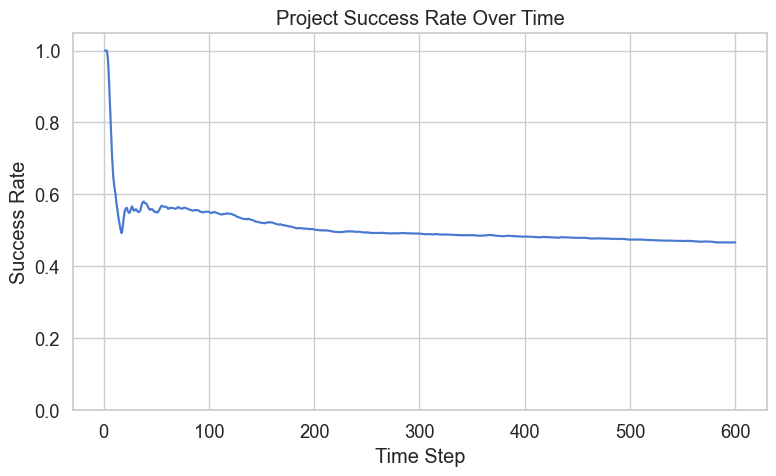

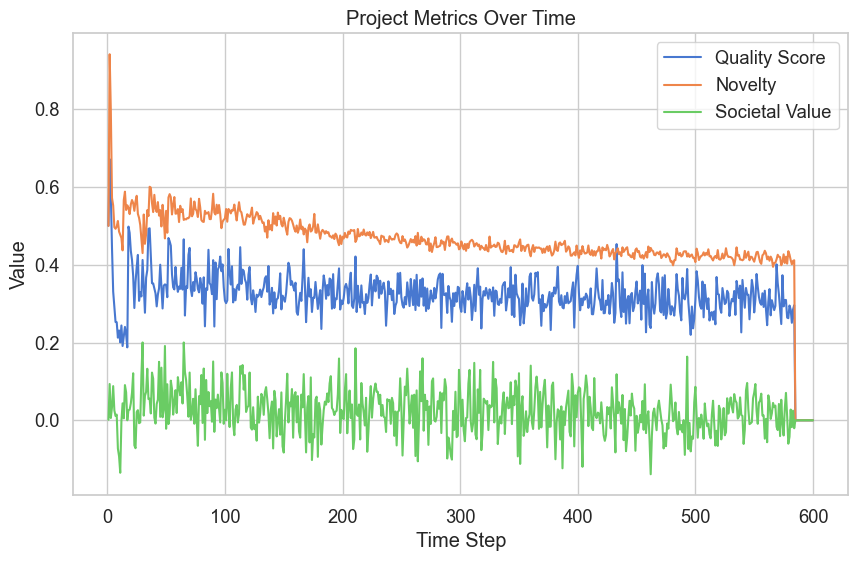

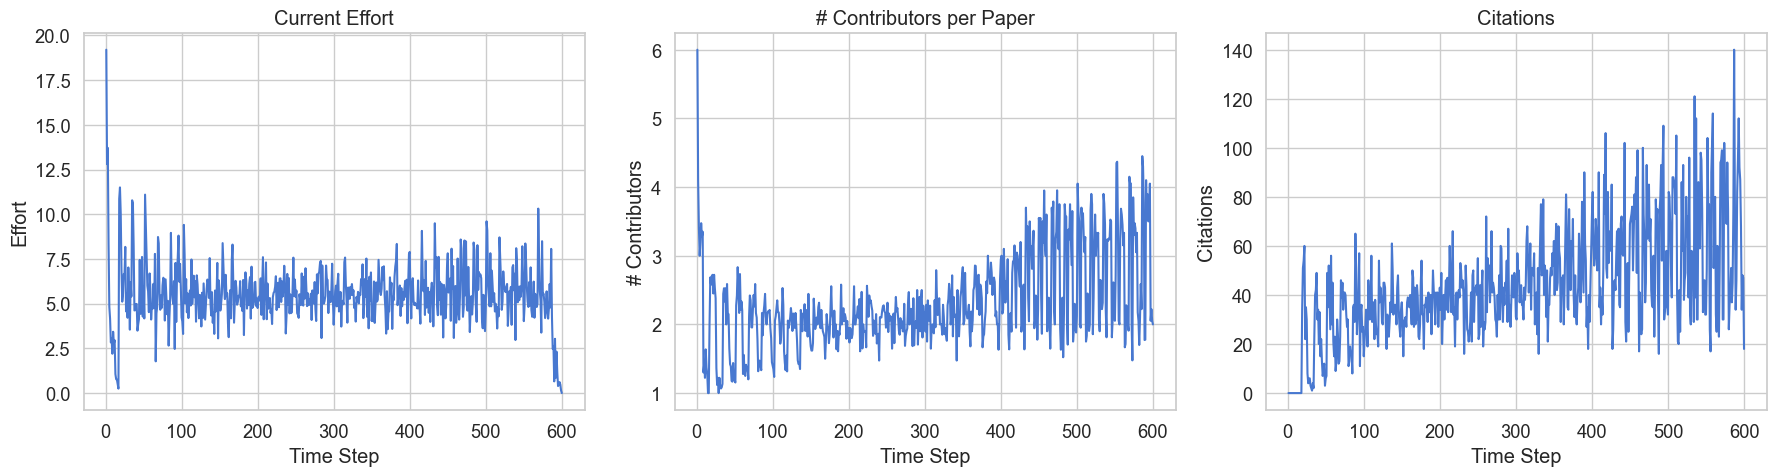

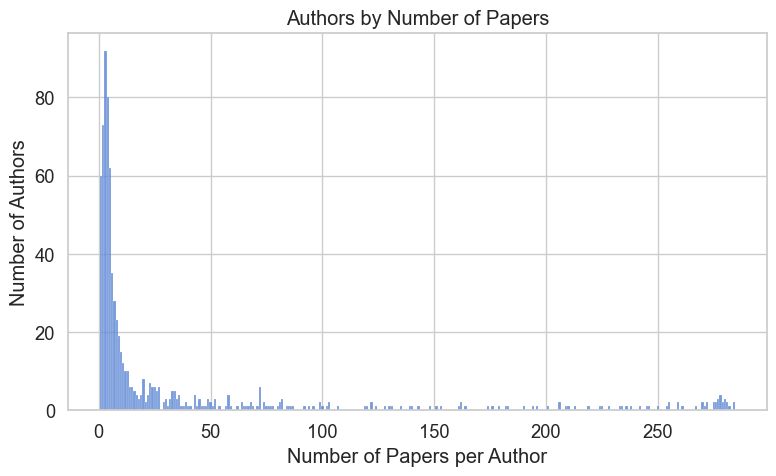

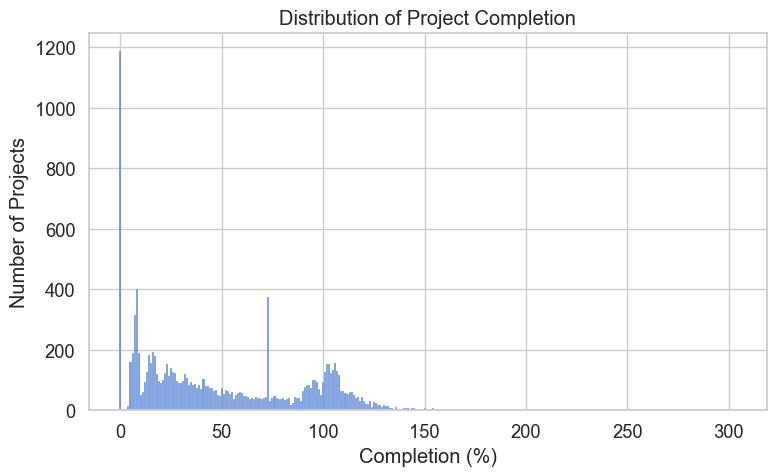

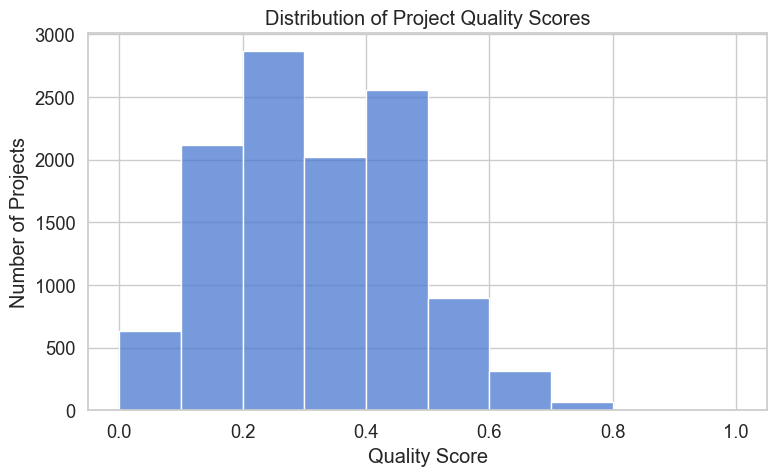

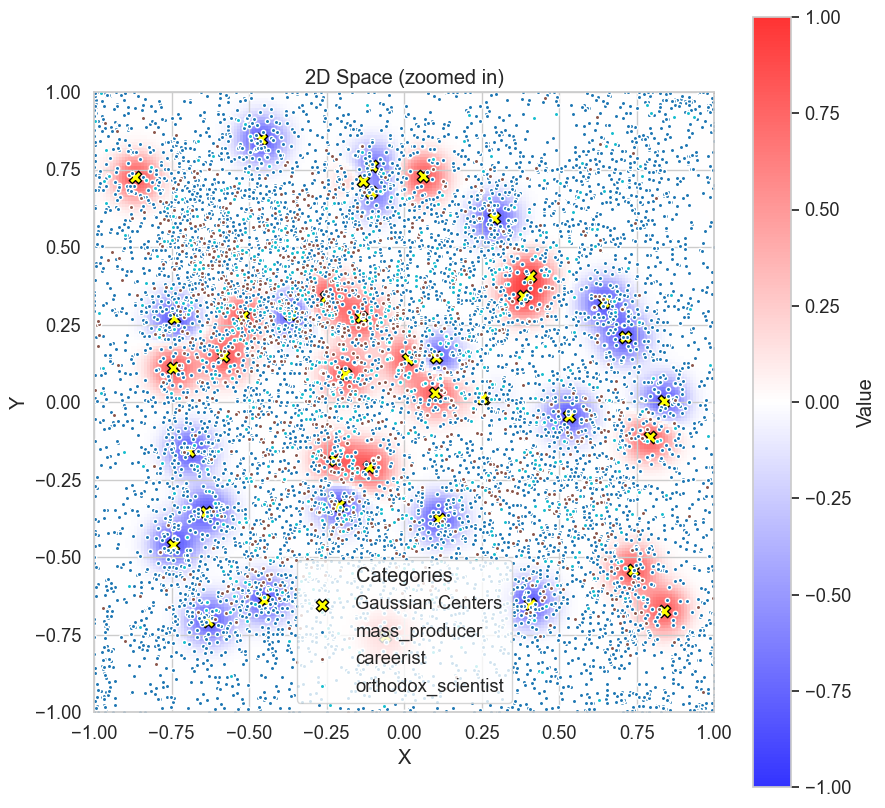

In [5]:
visualize_policy_population_proportion(balanced_evenly_actions)
visualize_policy_population(balanced_evenly_actions)
plot_histograms(balanced_evenly_projects, balanced_evenly_actions, "../log/balanced_evenly_area.pickle")

<Figure size 640x480 with 0 Axes>

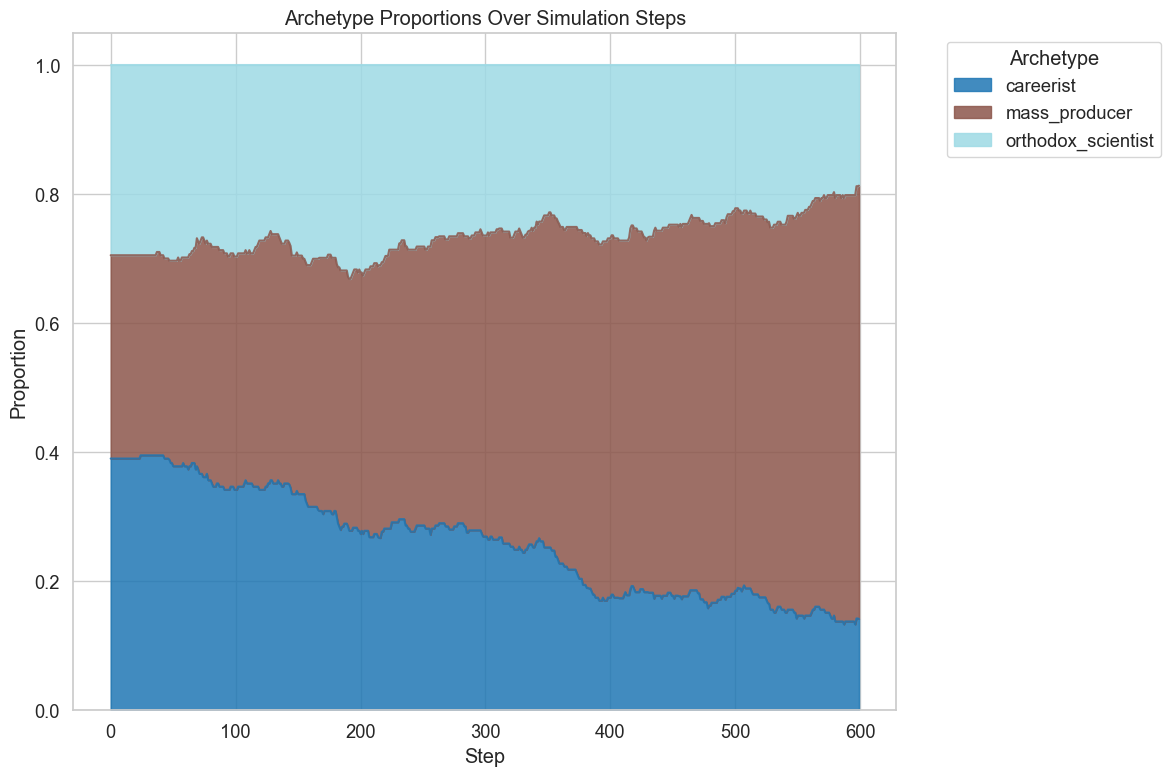

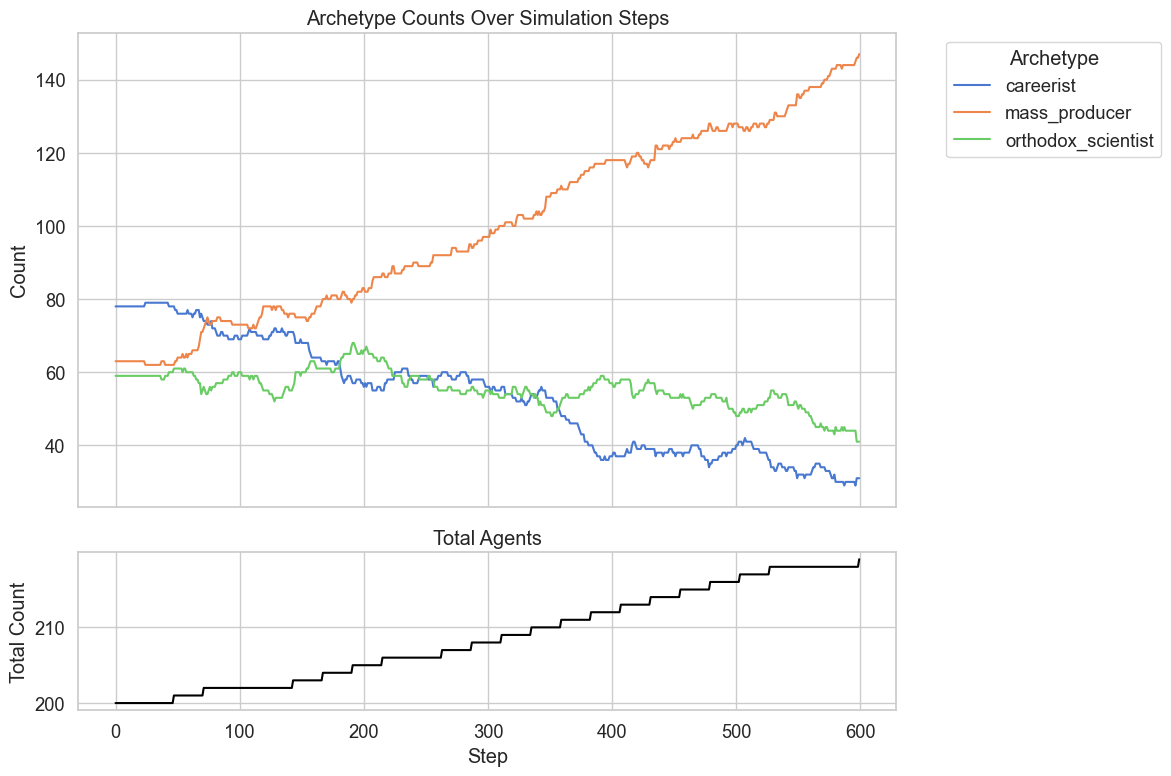

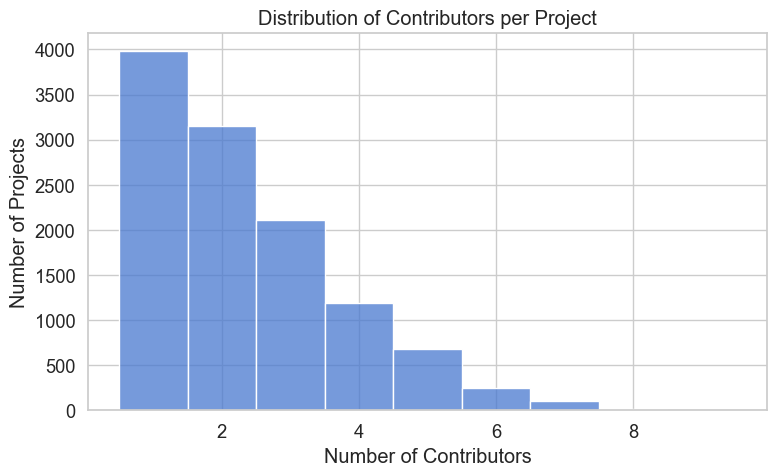

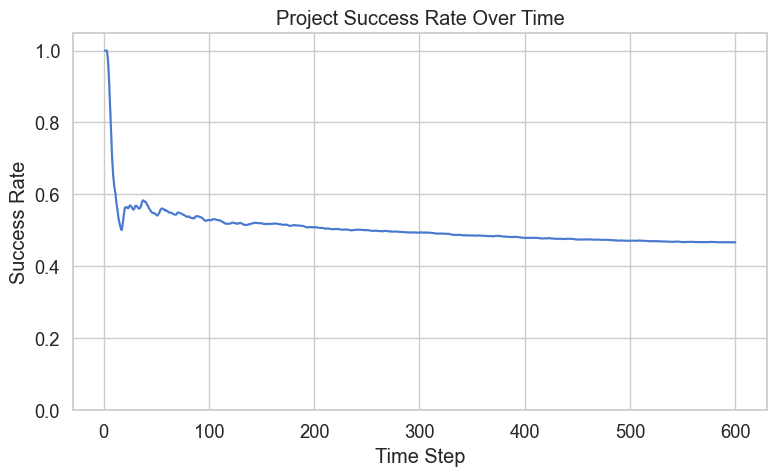

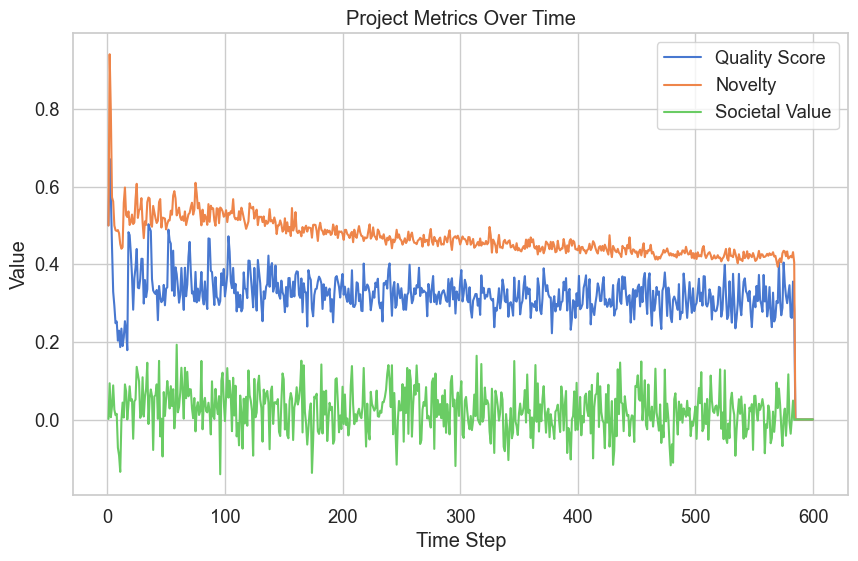

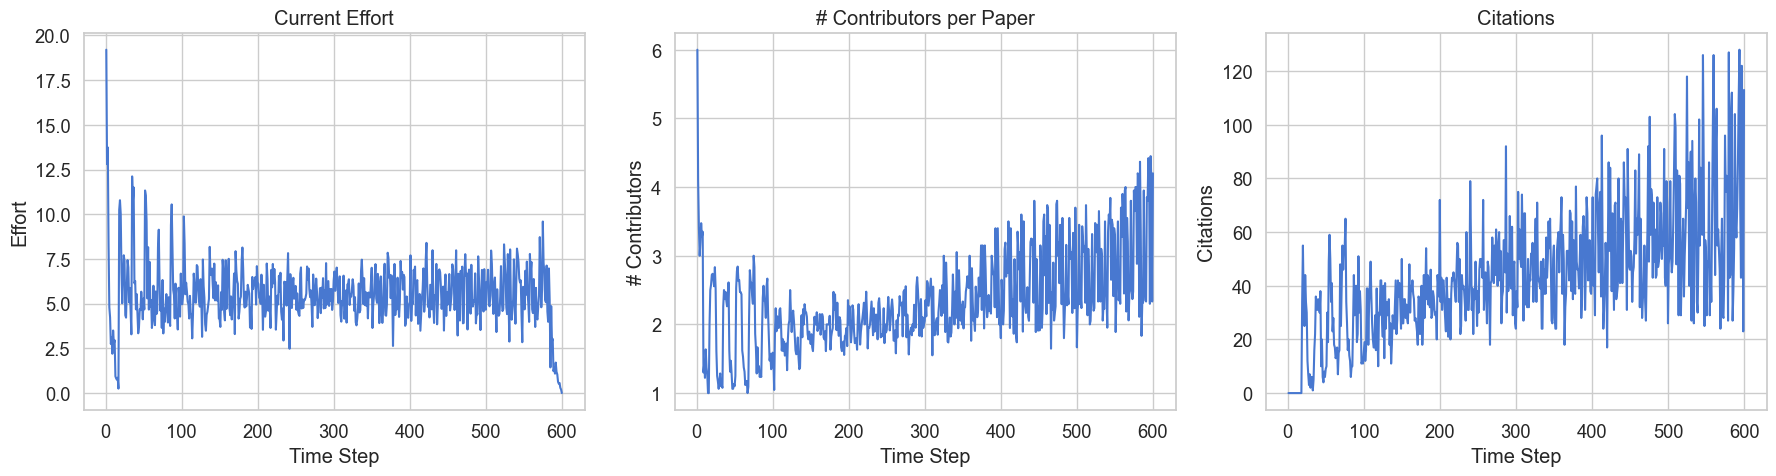

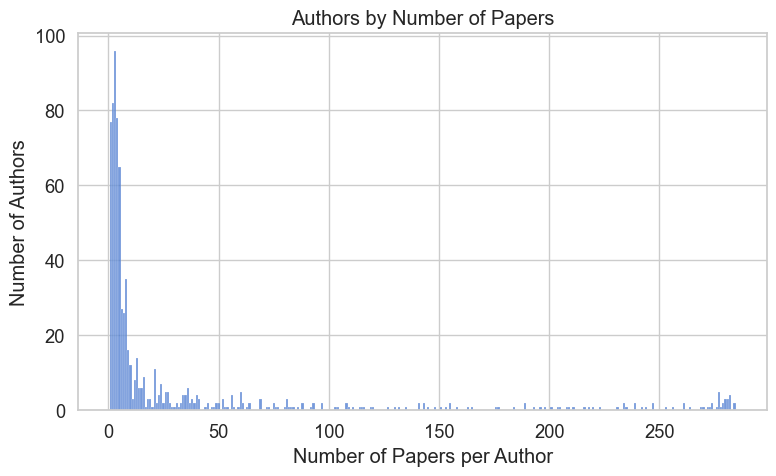

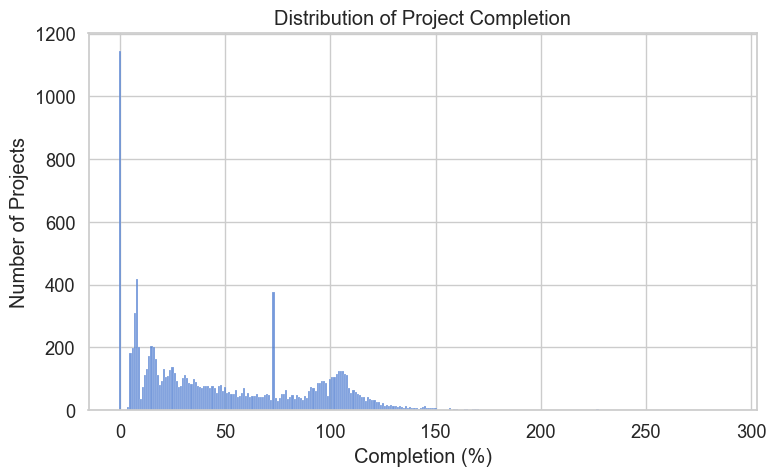

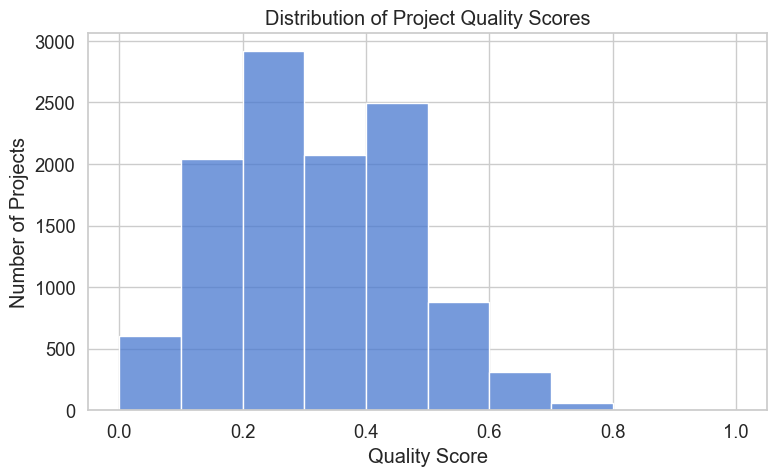

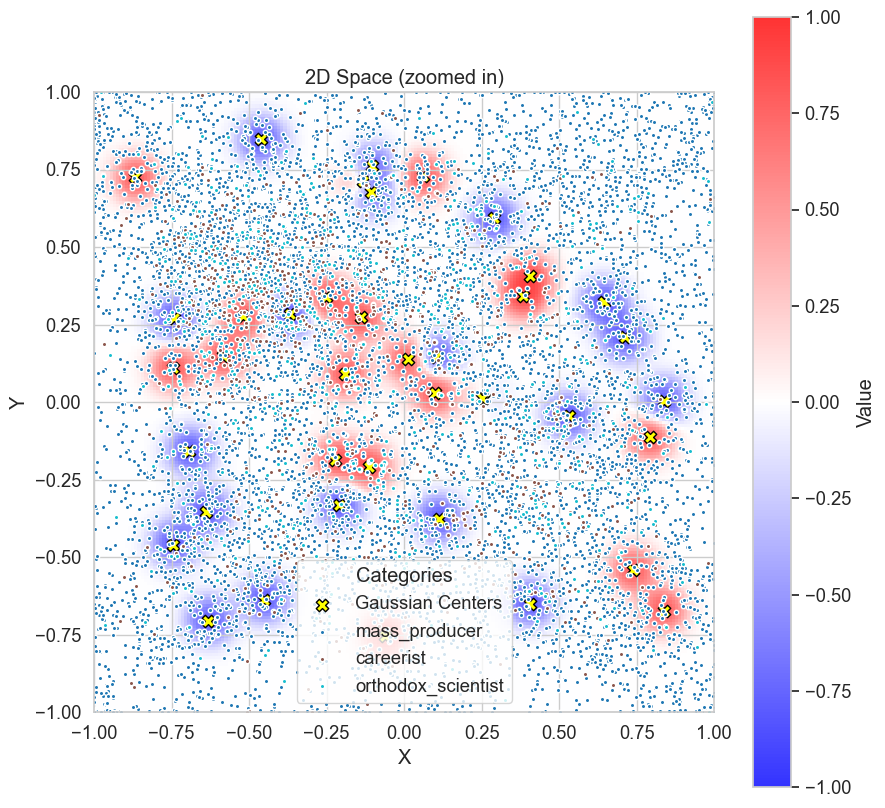

In [6]:
visualize_policy_population_proportion(balanced_by_effort_actions)
visualize_policy_population(balanced_by_effort_actions)
plot_histograms(balanced_by_effort_projects, balanced_by_effort_actions, "../log/balanced_by_effort_area.pickle")

In [ ]:
# Load projects list from JSON file
with open("../log/debug_sim_projects.json", "r") as f:
   debug_projects = json.load(f)


In [ ]:
plot_histograms(debug_projects, "../log/debug_sim_actions.pickle")

In [ ]:
# Load observations list from JSON file
debug_obs = []
with open("../log/debug_sim_observations.jsonl", "r") as f:
    for line in f.readlines():
        debug_obs.append(json.loads(line.strip()))

In [ ]:
len(debug_obs)

2000

In [ ]:
len([o for o in debug_obs[0] if o is not None])

100

In [ ]:
debug_projects[0]

{'project_id': 'project_0-0-1',
 'required_effort': 9,
 'prestige': 0.6357000247046045,
 'time_window': 18.0,
 'peer_fit': [0.5],
 'novelty': 0.07366188122867724,
 'current_effort': 3.0,
 'contributors': [83],
 'start_time': 1,
 'finished': True,
 'final_reward': 0.6357000247046045,
 'kene': [-0.1648667394196213, 0.8356515056102948],
 'citations': [],
 'cited_by': ['project_1162-5-334', 'project_1162-5-334'],
 'generator_project_id': None,
 'validation_noise': 1.0640373313732217,
 'quality_score': 0.43386180003985036}

237
8
9
7


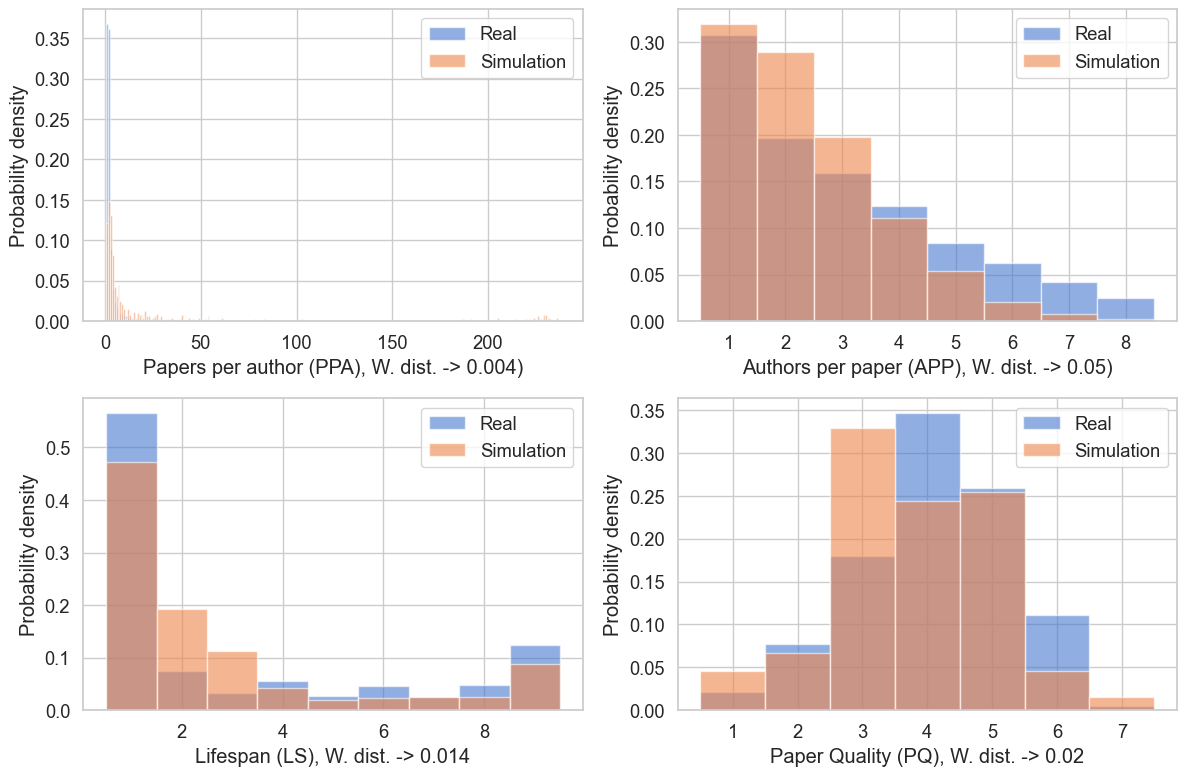

In [ ]:
from calibrate import build_normalized_hist, build_stats, plot_calibration_overlays, truncate_right_tail
# Load real data
  # leave as-is

# Load sim data
with open("../log/balanced_multiply_projects.json", "r") as f:
    run_projects = json.load(f)

sim_data = build_stats(run_projects)
sim_hists = {}
sim_centers = {}
real_papers_per_author = np.load("../papers_per_author.npy")
real_authors_per_paper = np.load("../authors_per_paper.npy")
real_lifespan = np.load("../author_lifespan.npy")
real_quality = np.load("../quality_histogram.npy")
n_bins_ppa = min(max(sim_data["papers_per_author"]), max(real_papers_per_author)) #200
n_bins_ppa = (2 if n_bins_ppa <= 2 else n_bins_ppa)
n_bins_app = min(max(sim_data["authors_per_paper"]), max(real_authors_per_paper)) #
n_bins_app = (2 if n_bins_app <= 2 else n_bins_app)
n_bins_ls = min(int(max(sim_data["lifespan"])),max(real_lifespan)) #
n_bins_ls = (2 if n_bins_ls <= 2 else n_bins_ls)
n_bins_q = min(int(max(sim_data["quality"])),max(real_quality)) #
n_bins_q = (2 if n_bins_q <= 2 else n_bins_q)
print(n_bins_ppa)
print(n_bins_app)
print(n_bins_ls)
print(n_bins_q)
counts, centers = build_normalized_hist(sim_data["papers_per_author"], n_bins_ppa)
sim_hists["papers_per_author"], sim_centers["papers_per_author"] = counts, centers

counts, centers = build_normalized_hist(sim_data["authors_per_paper"], n_bins_app)
sim_hists["authors_per_paper"], sim_centers["authors_per_paper"] = counts, centers

counts, centers = build_normalized_hist(np.array(sim_data["lifespan"]), n_bins_ls)
sim_hists["lifespan"], sim_centers["lifespan"] = counts, centers

counts, centers = build_normalized_hist(np.array(sim_data["quality"]), n_bins_q)
sim_hists["quality"], sim_centers["quality"] = counts, centers


real_data = {}
real_centers = {}
counts, centers = build_normalized_hist(truncate_right_tail(real_papers_per_author, max_value=n_bins_ppa), n_bins_ppa)
real_data["papers_per_author"], real_centers["papers_per_author"] = counts, centers

counts, centers = build_normalized_hist(truncate_right_tail(real_authors_per_paper[real_authors_per_paper>0], max_value=n_bins_app), n_bins_app)
real_data["authors_per_paper"], real_centers["authors_per_paper"] = counts, centers

counts, centers = build_normalized_hist(real_lifespan, n_bins_ls)
real_data["lifespan"], real_centers["lifespan"] = counts, centers

counts, centers = build_normalized_hist(real_quality, n_bins_q)
real_data["quality"], real_centers["quality"] = counts, centers

real_data["acceptance"] = np.load("../acceptance_histogram.npy")

# def plot_calibration_overlays(real_data, sim_data, outfile=None):
#     """
#     Plots overlayed line plots of real vs simulation histograms.
#     Both real_data and sim_data should contain normalized histograms
#     (same number of bins per metric).
#     """
#     metrics = [
#         ("papers_per_author", "Distribution of Papers per Author", "Papers per author"),
#         ("authors_per_paper", "Authors per Paper", "Authors per paper"),
#         ("lifespan", "Career Length", "Years active"),
#         ("quality", "Paper Quality", "Quality score"),
#     ]

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for ax, (key, title, xlabel) in zip(axes.flatten(), metrics):
#         y_real = real_data[key]
#         y_sim = sim_data[key]
#         x = np.arange(len(y_real))  # bin indices as x-axis
#         ax.plot(x, y_real, label="Real", lw=2)
#         ax.plot(x, y_sim, label="Simulation", lw=2, linestyle="--")
#         ax.set_title(title)
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel("Probability density")
#         ax.legend()

#     plt.tight_layout()
#     if outfile:
#         plt.savefig(outfile, dpi=300)
#     plt.show()

def plot_calibration_overlays(real_data, sim_data, outfile=None):
    """
    Plots overlayed histograms of real vs simulation data.
    Both real_data and sim_data should contain normalized histograms
    (same number of bins per metric).
    """
    metrics = [
        ("papers_per_author", "", "Papers per author (PPA), W. dist.: 0.004)"),
        ("authors_per_paper", "", "Authors per paper (APP), W. dist.: 0.05)"),
        ("lifespan", "", "Lifespan (LS), W. dist.: 0.014"),
        ("quality", "", "Paper Quality (PQ), W. dist.: 0.02"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for ax, (key, _, xlabel) in zip(axes.flatten(), metrics):
        y_real = real_data[key]
        y_sim = sim_data[key]
        x = np.arange(len(y_real))+1  # bin indices as x-axis

        # Overlayed histograms (transparent bars)
        ax.bar(x, y_real, width=1.0, alpha=0.6, label="Real")
        ax.bar(x, y_sim, width=1.0, alpha=0.6, label="Simulation")

        # ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Probability density")
        ax.legend()

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()



# Example call
plot_calibration_overlays(real_data, sim_hists,# real_centers, sim_centers,
    outfile="calibration_overlay.png")

In [24]:
Counter(real_authors_per_paper).most_common()

[(np.int64(1), 2788),
 (np.int64(2), 1784),
 (np.int64(3), 1438),
 (np.int64(4), 1123),
 (np.int64(5), 764),
 (np.int64(6), 564),
 (np.int64(7), 380),
 (np.int64(0), 378),
 (np.int64(8), 223),
 (np.int64(9), 162),
 (np.int64(10), 133),
 (np.int64(11), 68),
 (np.int64(12), 44),
 (np.int64(13), 41),
 (np.int64(14), 26),
 (np.int64(16), 15),
 (np.int64(15), 11),
 (np.int64(17), 10),
 (np.int64(18), 8),
 (np.int64(21), 5),
 (np.int64(19), 4),
 (np.int64(20), 3),
 (np.int64(30), 3),
 (np.int64(40), 2),
 (np.int64(24), 2),
 (np.int64(44), 2),
 (np.int64(34), 2),
 (np.int64(22), 2),
 (np.int64(36), 2),
 (np.int64(27), 2),
 (np.int64(26), 2),
 (np.int64(23), 2),
 (np.int64(100), 2),
 (np.int64(69), 1),
 (np.int64(28), 1),
 (np.int64(60), 1),
 (np.int64(43), 1),
 (np.int64(29), 1)]

In [25]:
Counter(real_papers_per_author).most_common()

[(np.int64(0), 3669),
 (np.int64(1), 3608),
 (np.int64(2), 893),
 (np.int64(3), 400),
 (np.int64(4), 241),
 (np.int64(5), 159),
 (np.int64(6), 120),
 (np.int64(7), 94),
 (np.int64(8), 81),
 (np.int64(10), 68),
 (np.int64(9), 58),
 (np.int64(11), 48),
 (np.int64(15), 38),
 (np.int64(13), 35),
 (np.int64(12), 35),
 (np.int64(14), 26),
 (np.int64(16), 21),
 (np.int64(17), 20),
 (np.int64(18), 20),
 (np.int64(21), 18),
 (np.int64(19), 17),
 (np.int64(20), 15),
 (np.int64(27), 13),
 (np.int64(26), 12),
 (np.int64(24), 12),
 (np.int64(23), 11),
 (np.int64(41), 11),
 (np.int64(25), 11),
 (np.int64(22), 10),
 (np.int64(28), 9),
 (np.int64(35), 8),
 (np.int64(32), 7),
 (np.int64(37), 6),
 (np.int64(70), 6),
 (np.int64(39), 6),
 (np.int64(29), 5),
 (np.int64(38), 5),
 (np.int64(43), 5),
 (np.int64(33), 5),
 (np.int64(45), 5),
 (np.int64(48), 5),
 (np.int64(42), 5),
 (np.int64(31), 4),
 (np.int64(46), 4),
 (np.int64(36), 4),
 (np.int64(86), 4),
 (np.int64(50), 4),
 (np.int64(44), 4),
 (np.int64(7

In [13]:
def plot_sobol_indices(json_files, output_labels, title="Sobol Sensitivity Indices"):
    """
    Plot S1 and ST Sobol sensitivity indices across multiple outputs.

    Parameters
    ----------
    json_files : list of str or Path
        Paths to JSON files containing 'S1' and 'ST' results.
    output_labels : list of str
        Names of output metrics (e.g., ["PPA", "APP", "CL", "PQ", "AR"]).
    title : str
        Plot title.
    """

    # Load all files
    sobol_data = []
    for f in json_files:
        with open(f, "r") as jf:
            sobol_data.append(json.load(jf))

    # Assume all have the same parameter order
    params = list(sobol_data[0]["S1"].keys())
    n_params = len(params)
    n_outputs = len(sobol_data)

    # Build matrices for S1 and ST
    S1 = np.zeros((n_params, n_outputs))
    ST = np.zeros((n_params, n_outputs))

    for j, data in enumerate(sobol_data):
        for i, p in enumerate(params):
            S1[i, j] = data["S1"][p]
            ST[i, j] = data["ST"][p]

    # Plot
    fig, axes = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 5), sharey=True)
    if n_outputs == 1:
        axes = [axes]

    for j, ax in enumerate(axes):
        x = np.arange(n_params)
        width = 0.35

        ax.bar(x - width/2, S1[:, j], width, label="$S_j$ (First-order)")
        ax.bar(x + width/2, ST[:, j], width, label="$S^T_j$ (Total-order)")

        ax.set_xticks(x)
        ax.set_xticklabels(params, rotation=45, ha="right")
        ax.set_title(output_labels[j])
        ax.grid(True, axis="y", linestyle="--", alpha=0.5)
        ax.set_ylim(bottom=min(np.min(S1), np.min(ST), -0.05))

    axes[0].set_ylabel("Sensitivity Index")
    fig.suptitle(title, fontsize=14)
    fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.05))
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

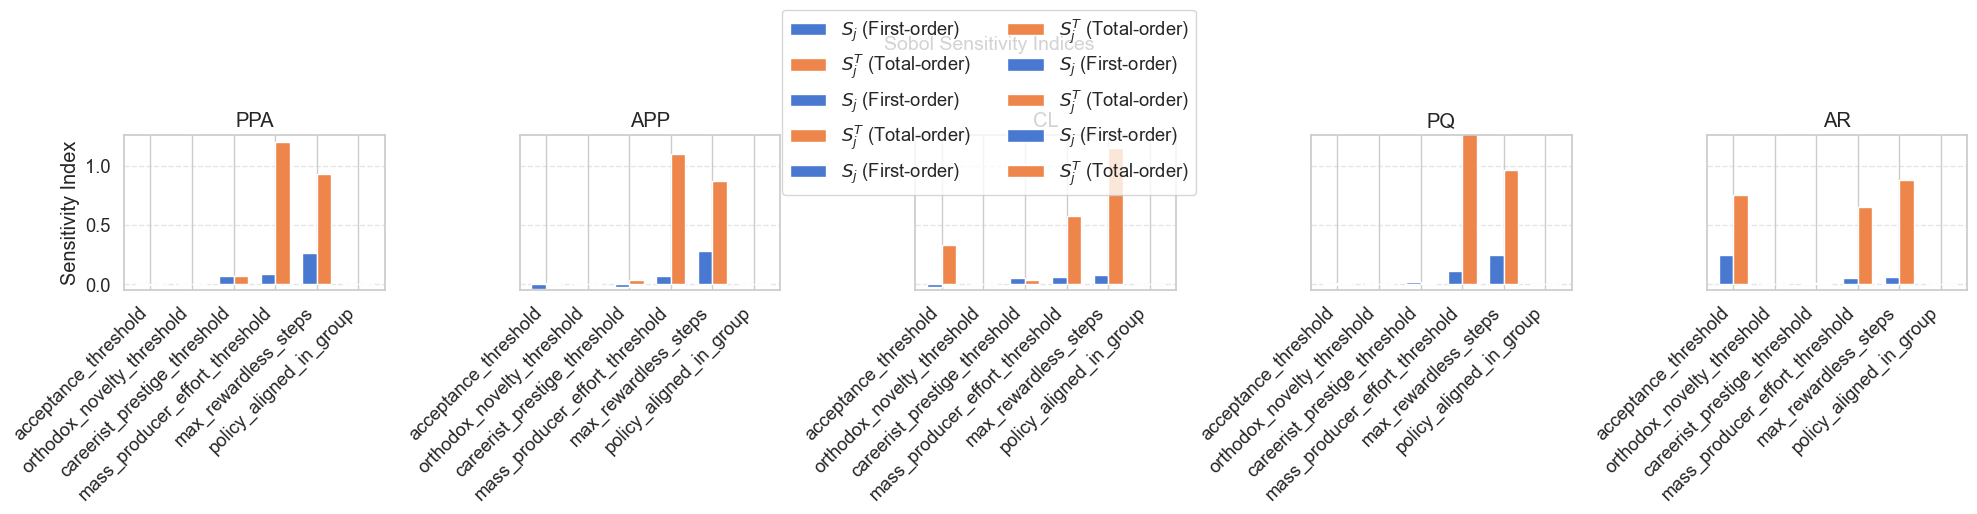

In [21]:
json_files = [
    "../sensitivity_papers_per_author.json",
    "../sensitivity_authors_per_paper.json",
    "../sensitivity_lifespan.json",
    "../sensitivity_quality.json",
    "../sensitivity_acceptance.json",
]

output_labels = ["PPA", "APP", "CL", "PQ", "AR"]

plot_sobol_indices(json_files, output_labels)